In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import import_ipynb
from coare36vn_zrf_et import psiu_40, psiu_26
from metpy import calc
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
from scipy.optimize import curve_fit, Bounds, minimize
from scipy.stats import norm
from lmfit import Model

# Read in LES

In [2]:
LES_data = 'MidPlane_means_HighWind_lowTGrad.csv'
#LES_data = 'MidPlane_means.csv'
if 'HighWind' in LES_data: save_str = 'HW'
else: save_str = 'conv'

In [3]:
LES_df = pd.read_csv(LES_data)
if 'HighWind' in LES_data: LES_df = LES_df.drop('Unnamed: 15', axis=1).dropna()
x_coast = LES_df['X'].unique() - 3000
height = LES_df['Z'].unique()

# Create an xarray Dataset with the 2D data
ds = xr.Dataset(
    coords={
        'Height': height,
        'X_coast': x_coast,
    }
)

for n,name in enumerate(LES_df.columns.to_list()):
    if name=='X' or name=='Z':
        continue
    else:
        # Expand the variables to 2D by repeating along the Z axis (broadcasting)
        var_tmp = LES_df[name].values
        var_2d = np.reshape(var_tmp, (len(height), len(x_coast)))
        
        name = name.replace("'", 'p')
        name = name.replace('THETA', 'T')
        name = name.replace(' ', '')
        ds[name] = (['Height', 'X_coast'], var_2d)   
ds

<xarray.Dataset> Size: 4MB
Dimensions:  (Height: 119, X_coast: 320)
Coordinates:
  * Height   (Height) float64 952B 0.7906 2.384 4.004 5.65 ... 479.7 487.5 495.5
  * X_coast  (X_coast) float64 3kB -996.1 -988.3 -980.5 ... 1.488e+03 1.496e+03
Data variables: (12/13)
    U        (Height, X_coast) float64 305kB 4.98 5.004 5.005 ... 6.77 6.772
    W        (Height, X_coast) float64 305kB -0.002387 -0.00148 ... 0.03278
    V        (Height, X_coast) float64 305kB -0.03216 -0.02312 ... 0.01933
    T        (Height, X_coast) float64 305kB 286.9 286.9 286.9 ... 299.6 299.6
    UpUp     (Height, X_coast) float64 305kB 0.6447 0.6238 ... 0.001192 0.001192
    WpWp     (Height, X_coast) float64 305kB 0.0253 0.02273 ... 0.001037
    ...       ...
    TKE      (Height, X_coast) float64 305kB 0.5258 0.5088 ... 0.001536 0.001534
    TpTp     (Height, X_coast) float64 305kB 0.008681 0.003832 ... 0.0005661
    UpWp     (Height, X_coast) float64 305kB -0.01755 -0.02274 ... -1.27e-05
    WpTp     (Height, X_coast) float64 305kB -0.0001153 ... -0.0002494
    UpVp     (Height, X_coast) float64 305kB -0.1487 -0.1332 ... -8.52e-05
    VpWp     (Height, X_coast) float64 305kB 0.03375 0.02711 ... -0.0002203

## Diagnostics

In [4]:
g = 9.81
vonk = 0.4
f = 2*np.sin(36.8*np.pi/180)*(7.29e-5)

wsp = (ds.U**2 + ds.V**2 + ds.W**2)**(1/2)
hwsp = (ds.U**2 + ds.V**2)**(1/2)
ust = (ds.UpWp**2 + ds.VpWp**2)**(1/4)
wst3 = (ds.Height*g*ds.WpTp / ds.T)**(1)
Lob = -(ds.T*ust**3) / (vonk*g*ds.WpTp)
zL = ds.Height / Lob
Tadv = np.tile(ds.X_coast.values, (len(ds.Height.values), 1)) / ds.U.values
gamma = calc.first_derivative(ds.T)
N2 = (g/ds.T)*gamma

psiu = np.zeros(zL.values.shape, dtype=float)
for z,height in enumerate(ds.Height.values):
    psiu[z,:] = psiu_40(zL.isel(Height=z).values)

psiu[psiu < -100] = np.nan
z0 = np.transpose(np.tile(ds.Height.values, (len(ds.X_coast.values), 1))) * np.exp(-(vonk*wsp/ust + psiu))

ds['wsp'] = (['Height', 'X_coast'], wsp.values)   
ds['hwsp'] = (['Height', 'X_coast'], hwsp.values)   
ds['ustar'] = (['Height', 'X_coast'], ust.values)   
ds['wstar3'] = (['Height', 'X_coast'], wst3.values)   
ds['L_ob'] = (['Height', 'X_coast'], Lob.values)   
ds['zL'] = (['Height', 'X_coast'], zL.values)   
ds['Tadv'] = (['Height', 'X_coast'], Tadv)
ds['z0'] = (['Height', 'X_coast'], z0.values)
ds

<xarray.Dataset> Size: 6MB
Dimensions:  (Height: 119, X_coast: 320)
Coordinates:
  * Height   (Height) float64 952B 0.7906 2.384 4.004 5.65 ... 479.7 487.5 495.5
  * X_coast  (X_coast) float64 3kB -996.1 -988.3 -980.5 ... 1.488e+03 1.496e+03
Data variables: (12/21)
    U        (Height, X_coast) float64 305kB 4.98 5.004 5.005 ... 6.77 6.772
    W        (Height, X_coast) float64 305kB -0.002387 -0.00148 ... 0.03278
    V        (Height, X_coast) float64 305kB -0.03216 -0.02312 ... 0.01933
    T        (Height, X_coast) float64 305kB 286.9 286.9 286.9 ... 299.6 299.6
    UpUp     (Height, X_coast) float64 305kB 0.6447 0.6238 ... 0.001192 0.001192
    WpWp     (Height, X_coast) float64 305kB 0.0253 0.02273 ... 0.001037
    ...       ...
    ustar    (Height, X_coast) float64 305kB 0.195 0.1881 ... 0.01488 0.01485
    wstar3   (Height, X_coast) float64 305kB -3.116e-06 -2.747e-06 ... -0.004047
    L_ob     (Height, X_coast) float64 305kB 4.706e+03 4.789e+03 ... 1.013 1.003
    zL       (Height, X_coast) float64 305kB 0.000168 0.0001651 ... 489.3 494.0
    Tadv     (Height, X_coast) float64 305kB -200.0 -197.5 ... 219.8 220.9
    z0       (Height, X_coast) float64 305kB 2.901e-05 1.891e-05 ... nan nan

# Functions

In [37]:
def logistic(x, k=1, x0=0, L=1):
    return L / (1 + np.exp(-k*(x-x0)))

def loss(params, x, y):
    k, x0, L = params
    return np.sum((logistic(x, k, x0, L) - y)**2)

def tanh(x, k, x0, L):
    return L/2 + k*np.tanh(x-x0)

def sinh(x, k, x0, L):
    return L - k*np.tanh(x0*x)

def loss2(params, x, y):
    k, x0, L = params
    return np.sum((tanh(x, k, x0, L) - y)**2)

def loss_sinh(params, x, y):
    k, x0, L = params
    return np.sum((sinh(x, k, x0, L) - y)**2)

In [11]:
alph = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)']

# Plots

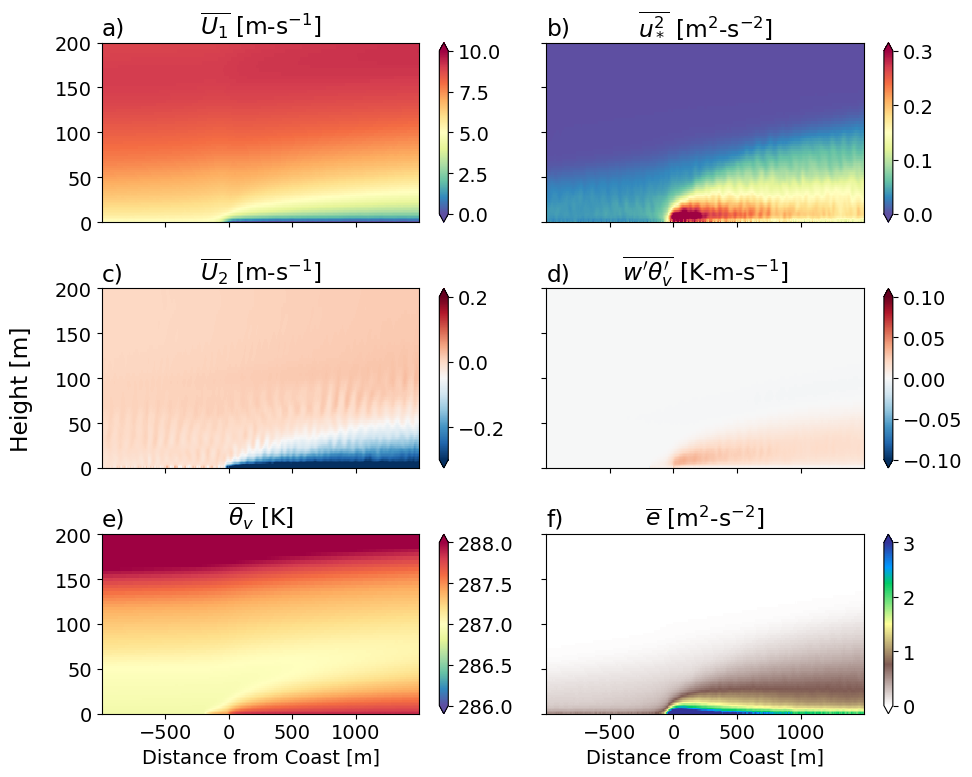

In [31]:
## quick plots
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(3,2, figsize=(10,8), sharex=True, sharey=True)
ax = ax.flatten()

cbar_args = {'label': ''}
labels = [
    r'$\overline{U_1}$ [m-s$^{-1}$]', 
    r'$\overline{u_*^2}$ [m$^2$-s$^{-2}$]', 
    r'$\overline{U_2}$ [m-s$^{-1}$]', 
    r'$\overline{w^{\prime}\theta_v^{\prime}}$ [K-m-s$^{-1}$]', 
    r'$\overline{\theta_v}$ [K]', 
    r'$\overline{e}$ [m$^2$-s$^{-2}$]', 
]

ds.U.plot(ax=ax[0], x='X_coast', y='Height', cmap='Spectral_r', vmin=0, vmax=10, extend='both', cbar_kwargs=cbar_args)
ds.V.plot(ax=ax[2], x='X_coast', y='Height', cmap='RdBu_r', vmin=-0.3, vmax=0.2, extend='both', cbar_kwargs=cbar_args)
ds.T.plot(ax=ax[4], x='X_coast', y='Height', cmap='Spectral_r', vmin=286, vmax=288, extend='both', cbar_kwargs=cbar_args)

(ds.ustar**2).plot(ax=ax[1], x='X_coast', y='Height', cmap='Spectral_r', vmin=0, vmax=0.3, extend='both', cbar_kwargs=cbar_args)
ds.WpTp.plot(ax=ax[3], x='X_coast', y='Height', cmap='RdBu_r', vmin=-0.1, vmax=0.1, extend='both', cbar_kwargs=cbar_args)
ds.TKE.plot(ax=ax[5], x='X_coast', y='Height', cmap='terrain_r', vmin=0, vmax=3, extend='both', cbar_kwargs=cbar_args)

for n,axis in enumerate(ax):
    axis.set_ylim([0, 200])
    axis.set_xlabel('')
    axis.set_ylabel('')
    if n>=4: axis.set_xlabel('Distance from Coast [m]')
    axis.set_title(f'{labels[n]}', loc='center')
    axis.set_title(f'{alph[n]}', loc='left')

fig.supylabel('Height [m]')
fig.tight_layout()

fig.savefig(f'LES_quick_look_{save_str}.png', bbox_inches='tight', dpi=300)
fig.savefig(f'LES_quick_look_{save_str}.pdf', bbox_inches='tight')

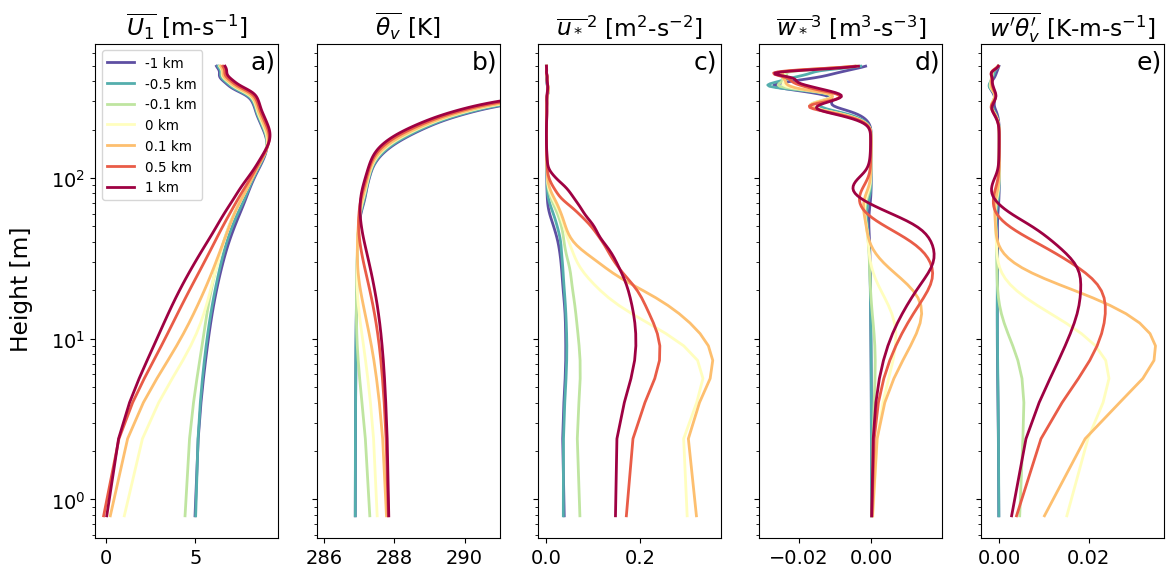

In [32]:
## quick plots
plt.rcParams.update({'font.size': 14})

xplt = [-996, -500, -100, 0, 100, 500, 1000]
xlabz = [-1, -0.5, -0.1, 0, 0.1, 0.5, 1]
N = len(xplt)
cmap = cm.Spectral_r
colors = cmap(np.linspace(0, 1, N)) 

fig, ax = plt.subplots(1,5, figsize=(12,6), sharex=False, sharey=True)
ax = ax.flatten()

cbar_args = {'label': ''}
labels = [
    r'$\overline{U_1}$ [m-s$^{-1}$]', 
    r'$\overline{\theta_v}$ [K]', 
    r'$\overline{u_*}^2$ [m$^2$-s$^{-2}$]', 
    r'$\overline{w_*}^3$ [m$^3$-s$^{-3}$]', 
    r'$\overline{w^{\prime}\theta_v^{\prime}}$ [K-m-s$^{-1}$]', 
]

for x, xdis in enumerate(xplt):
    ds.U.interp(X_coast=xdis).plot(ax=ax[0], y='Height', c=colors[x], lw=2, label=f'{xlabz[x]} km')
    ds.T.interp(X_coast=xdis).plot(ax=ax[1], y='Height', c=colors[x], lw=2, label=f'{xlabz[x]} km')
    (ds.ustar**2).interp(X_coast=xdis).plot(ax=ax[2], y='Height', c=colors[x], lw=2, label=f'{xlabz[x]} km') 
    (ds.wstar3).interp(X_coast=xdis).plot(ax=ax[3], y='Height', c=colors[x], lw=2, label=f'{xlabz[x]} km') 
    ds.WpTp.interp(X_coast=xdis).plot(ax=ax[4], y='Height', c=colors[x], lw=2, label=f'{xlabz[x]} km') 

ax[1].set_xlim([285.8, 291])
#ax[3].set_xlim([-0.1, 0.12])
for n,axis in enumerate(ax):
    #axis.set_ylim([0, 200])
    axis.set_yscale('log')
    axis.set_xlabel('')
    axis.set_ylabel('')
    #if n>=4: axis.set_xlabel('Distance from Coast [m]')
    axis.set_title(f'{labels[n]}', loc='center')
    width = axis.get_xlim()[1] - axis.get_xlim()[0]
    height = axis.get_ylim()[1] - axis.get_ylim()[0]
    axis.annotate(f'{alph[n]}', (axis.get_xlim()[1] - 0.15*width, axis.get_ylim()[1] - 0.3*height), fontsize=18)
    
ax[0].legend(fontsize='x-small', loc='upper left')

fig.supylabel('Height [m]')
fig.tight_layout()

fig.savefig(f'LES_quick_look_profiles_{save_str}.png', bbox_inches='tight', dpi=300)
fig.savefig(f'LES_quick_look_profiles_{save_str}.pdf', bbox_inches='tight')

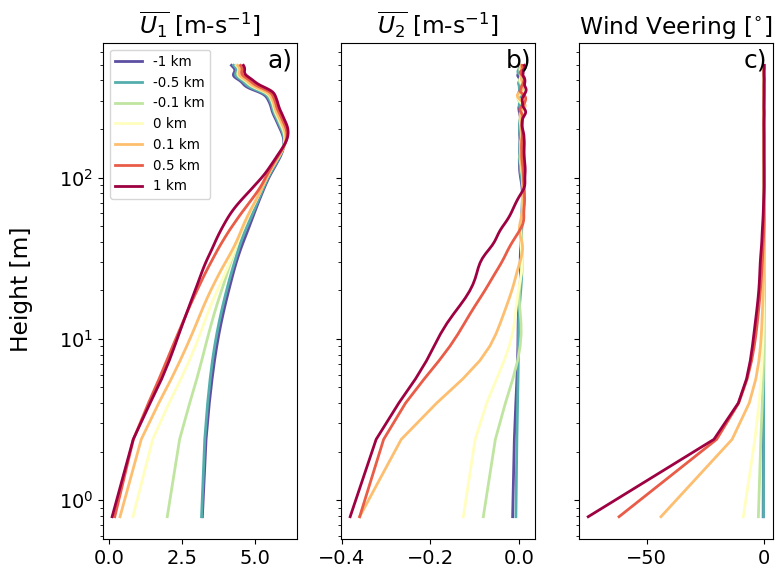

In [58]:
## quick plots
plt.rcParams.update({'font.size': 14})

xplt = [-996, -500, -100, 0, 100, 500, 1000]
xlabz = [-1, -0.5, -0.1, 0, 0.1, 0.5, 1]
N = len(xplt)
cmap = cm.Spectral_r
colors = cmap(np.linspace(0, 1, N)) 

fig, ax = plt.subplots(1,3, figsize=(8,6), sharex=False, sharey=True)
ax = ax.flatten()

cbar_args = {'label': ''}
labels = [
    r'$\overline{U_1}$ [m-s$^{-1}$]', 
    r'$\overline{U_2}$ [m-s$^{-1}$]', 
    r'Wind Veering [$^{\circ}$]', 
]

for x, xdis in enumerate(xplt):
    ds.U.interp(X_coast=xdis).plot(ax=ax[0], y='Height', c=colors[x], lw=2, label=f'{xlabz[x]} km')
    ds.V.interp(X_coast=xdis).plot(ax=ax[1], y='Height', c=colors[x], lw=2, label=f'{xlabz[x]} km')
    (np.atan2(ds.V.interp(X_coast=xdis), ds.U.interp(X_coast=xdis))*(180/np.pi)).plot(ax=ax[2], y='Height', c=colors[x], lw=2, label=f'{xlabz[x]} km')


#ax[1].set_xlim([285.8, 291])
#ax[3].set_xlim([-0.1, 0.12])
for n,axis in enumerate(ax):
    #axis.set_ylim([0, 200])
    axis.set_yscale('log')
    axis.set_xlabel('')
    axis.set_ylabel('')
    #if n>=4: axis.set_xlabel('Distance from Coast [m]')
    axis.set_title(f'{labels[n]}', loc='center')
    width = axis.get_xlim()[1] - axis.get_xlim()[0]
    height = axis.get_ylim()[1] - axis.get_ylim()[0]
    axis.annotate(f'{alph[n]}', (axis.get_xlim()[1] - 0.15*width, axis.get_ylim()[1] - 0.3*height), fontsize=18)
    
ax[0].legend(fontsize='x-small', loc='upper left')

fig.supylabel('Height [m]')
fig.tight_layout()

fig.savefig(f'LES_velocity_profiles_{save_str}.png', bbox_inches='tight', dpi=300)
fig.savefig(f'LES_velocity_profiles_{save_str}.pdf', bbox_inches='tight')

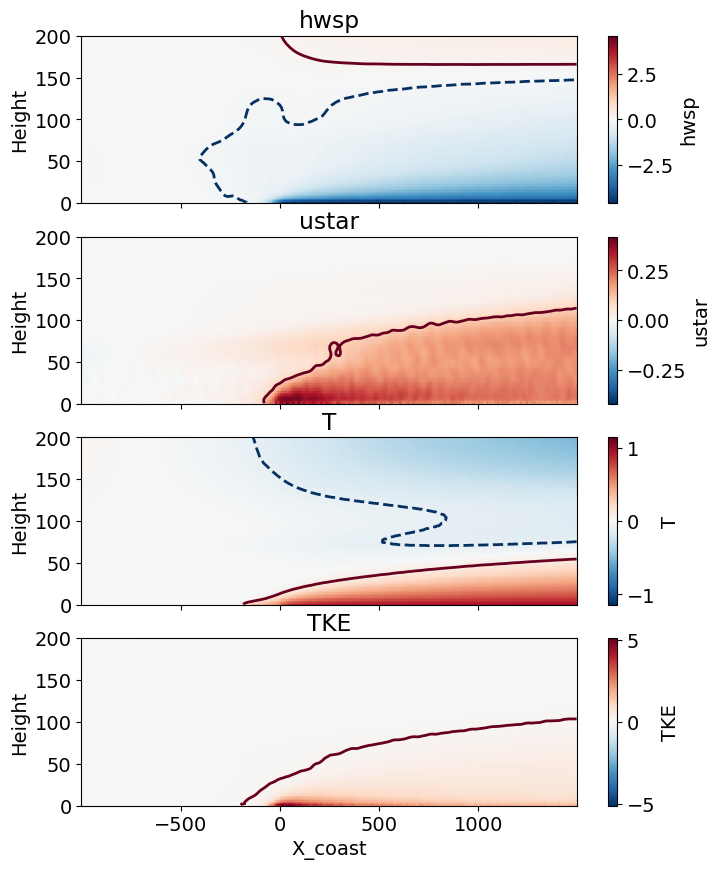

In [36]:
## quick plots

upstream_mask = (ds.X_coast <= -500)

fig, ax = plt.subplots(4,1, figsize=(8,10), sharex=True)
ax = ax.flatten()

for n,var in enumerate(['hwsp', 'ustar', 'T', 'TKE']):
    var_upstream = ds[var].where(upstream_mask, drop=True).mean(dim='X_coast')
    var_plt = ds[var] - var_upstream

    var_plt.plot(ax=ax[n], x='X_coast', y='Height')
    var_plt.plot.contour(ax=ax[n], x='X_coast', y='Height', levels=[-0.1, 0.1], linewidths=2)
    
    ax[n].set_title(f'{var}')
    ax[n].set_ylim([0, 200])
    if n<3: ax[n].set_xlabel('')

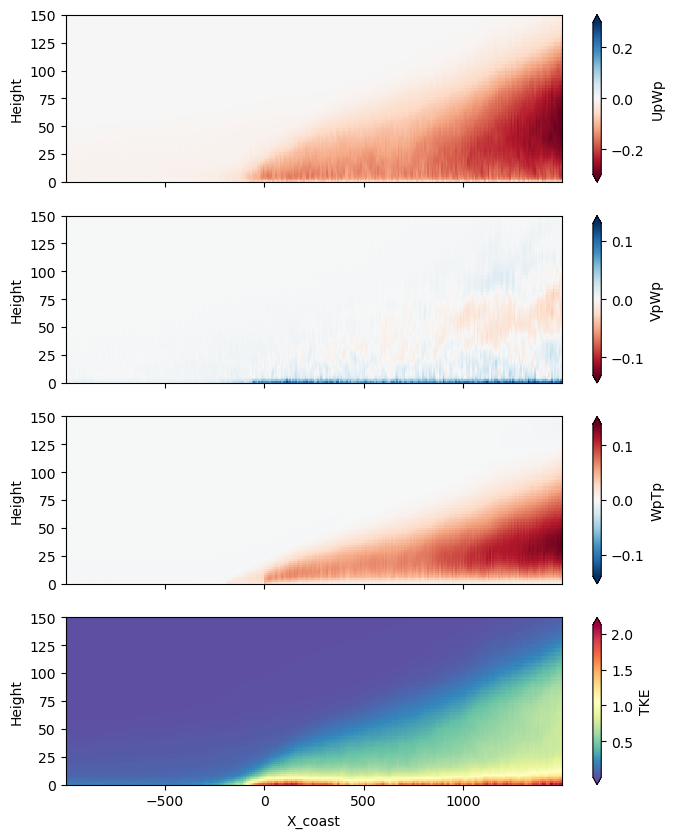

In [63]:
## quick plots

fig, ax = plt.subplots(4,1, figsize=(8,10), sharex=True)
ax = ax.flatten()

ds.UpWp.plot(ax=ax[0], x='X_coast', y='Height', cmap='RdBu', extend='both')
ds.VpWp.plot(ax=ax[1], x='X_coast', y='Height', cmap='RdBu', extend='both')
ds.WpTp.plot(ax=ax[2], x='X_coast', y='Height', cmap='RdBu_r',extend='both')
ds.TKE.plot(ax=ax[3], x='X_coast', y='Height', cmap='Spectral_r', extend='both')

for n,axis in enumerate(ax):
    axis.set_ylim([0, 150])
    if n<3: axis.set_xlabel('')

fig.savefig('LES_quick_look_fluxes.png', bbox_inches='tight', dpi=200)

/p/home/jhlywiak/miniforge3/envs/ABL-lmfit/lib/python3.13/site-packages/numpy/_core/function_base.py:301: RuntimeWarning: overflow encountered in power
  return _nx.power(base, y)


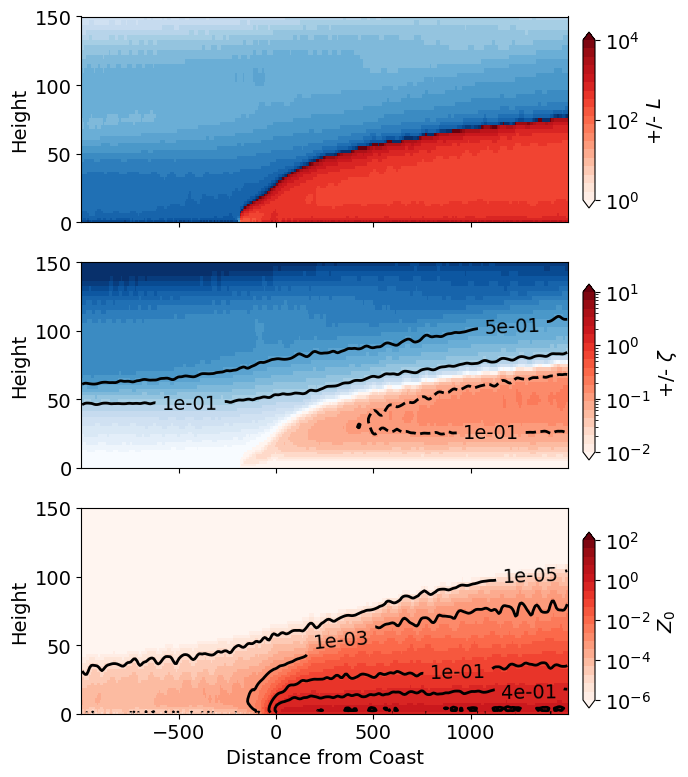

In [33]:
saveplt = 1

fig, ax = plt.subplots(3,1, figsize=(6,8), sharex=True, sharey=True)
ax = ax.flatten()

p0=(-1*ds.L_ob.where(ds.L_ob<=0)).plot(ax=ax[0], x='X_coast', y='Height', cmap='Reds',extend='both', 
                            levels=np.logspace(1, 10000, 20), norm=LogNorm(vmin=1, vmax=10000), add_colorbar=False)
                            #cbar_kwargs={'label': '(-) $L$'})
p00=ds.L_ob.where(ds.L_ob>=0).plot(ax=ax[0], x='X_coast', y='Height', cmap='Blues',extend='both', 
                            levels=np.logspace(1, 10000, 20), norm=LogNorm(vmin=1, vmax=10000), add_colorbar=False)
                            #cbar_kwargs={'label': '(+) $L$'})
p1=(-1*ds.zL.where(ds.zL<=0)).plot(ax=ax[1], x='X_coast', y='Height', cmap='Reds',extend='both', 
                            levels=np.logspace(0.01, 10, 20), norm=LogNorm(vmin=0.01, vmax=10), add_colorbar=False) 
                            #cbar_kwargs={'label': r'(-) $\zeta$'})
p11=ds.zL.where(ds.zL>=0).plot(ax=ax[1], x='X_coast', y='Height', cmap='Blues',extend='both', 
                            levels=np.logspace(0.01, 10, 20), norm=LogNorm(vmin=0.01, vmax=10), add_colorbar=False) 
                            #cbar_kwargs={'label': r'(+) $\zeta$'})
c1=(-1*ds.zL.where(ds.zL<=0)).plot.contour(ax=ax[1], x='X_coast', y='Height', 
                                           levels=[1e-1, 5e-1, 1, 1e1], linewidths=2, colors='k', linestyles='--')
c2=ds.zL.where(ds.zL>=0).plot.contour(ax=ax[1], x='X_coast', y='Height', 
                                      levels=[1e-1, 5e-1], linewidths=2, colors='k')

p2=ds.z0.where(ds.z0<10000).plot(ax=ax[2], x='X_coast', y='Height', cmap='Reds',extend='both', 
                              levels=np.logspace(1e-6, 100, 20), norm=LogNorm(vmin=1e-6, vmax=100), add_colorbar=False)
c3=ds.z0.where(ds.z0<10000).plot.contour(ax=ax[2], x='X_coast', y='Height', 
                                         levels=[1e-5, 1e-3, 1e-1, 0.42, 1], linewidths=2, colors='k')

plt.clabel(c1, inline=True, fmt='%.e')
plt.clabel(c2, inline=True, fmt='%.e')
plt.clabel(c3, inline=True, fmt='%.e')

for n,axis in enumerate(ax):
    axis.set_ylim([0, 150])
    axis.set_xlabel('')

ax[-1].set_xlabel('Distance from Coast')
fig.tight_layout()

cax0 = fig.add_axes([0.99, 0.725, 0.02, 0.22])
cax1 = fig.add_axes([0.99, 0.41, 0.02, 0.22])
cax2 = fig.add_axes([0.99, 0.1, 0.02, 0.22])
fig.colorbar(p0, cax0, label='+/- $L$')
fig.colorbar(p1, cax1, label=r'+/- $\zeta$')
fig.colorbar(p2, cax2, label='$Z_0$')

if saveplt == 1:
    fig.savefig(f'LES_zL_z0.png_{save_str}.png', bbox_inches='tight', dpi=200)
    fig.savefig(f'LES_zL_z0.png_{save_str}.pdf', bbox_inches='tight')

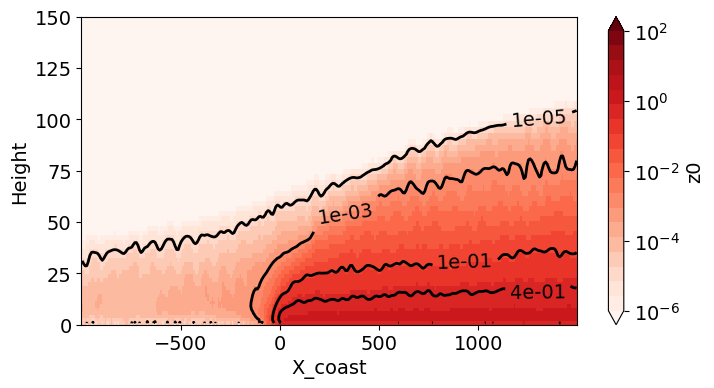

In [38]:
saveplt = 0

fig, ax = plt.subplots(1,1, figsize=(8,4), sharex=True)

ds.z0.where(ds.z0<10000).plot(ax=ax, x='X_coast', y='Height', cmap='Reds',extend='both', 
                              levels=np.logspace(1e-6, 100, 20), norm=LogNorm(vmin=1e-6, vmax=100))
c1=ds.z0.where(ds.z0<10000).plot.contour(ax=ax, x='X_coast', y='Height', 
                                         levels=[1e-5, 1e-3, 1e-1, 0.42], linewidths=2, colors='k')

plt.clabel(c1, inline=True, fmt='%.e')
ax.set_ylim([0, 150])

if saveplt == 1:
    fig.savefig('LES_2D_z0.png', bbox_inches='tight', dpi=200)

(0.0, 200.0)

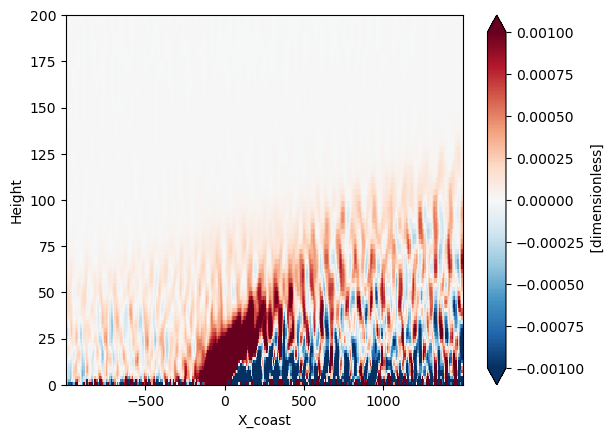

In [6]:
calc.first_derivative(ds.TKE, axis='X_coast').plot(x='X_coast', vmax=0.001)
ax=plt.gca()
ax.set_ylim([0, 200])

testing different parameters

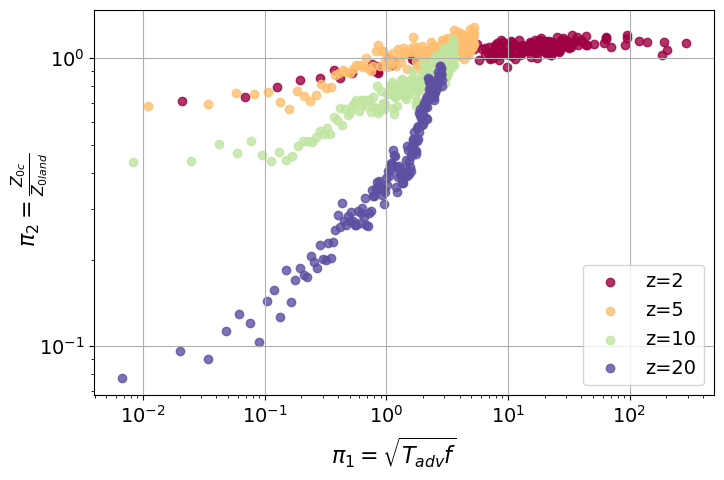

In [59]:
## all z0 below ~50 m

saveplt = 1

mask = (ds.X_coast >= 0) & (ds.X_coast <= 1400) & (ds.z0<1000) & (ds.z0>=1e-10) #& (ds.zL<=0.1) & (ds.zL>=-0.1)
qheight = [2, 5, 10, 20]
N = len(qheight)
cmap = cm.Spectral
colors = cmap(np.linspace(0, 1, N)) 
X, Z = np.meshgrid(ds.X_coast, ds.Height)

tke_adv = ds.U * calc.first_derivative(ds.TKE, axis='X_coast')
gamma = calc.first_derivative(ds.T, axis='Height')
tke = ds.TKE
tadv = (X/ds.U)
buoyancy = g/ds.T
N2 = buoyancy * gamma
f = 2*np.sin(36.5*np.pi/180)*(7.29e-5)
if 'HW' in save_str: dtdx = 1/2500
else: dtdx = 3/2500
z0_land = 1
z0_water = 0.00001

ds['Z'] = (['Height', 'X_coast'], Z)

pi1 = (tke_adv / (buoyancy*ds.WpTp)).where(mask, drop=True) 

#pi1 = 1/(tke_adv / (buoyancy*ds.WpTp)).where(mask, drop=True)
#pi1 = (tadv*buoyancy*ds.WpTp/tke).where(mask, drop=True)
#pi1 = (Z*buoyancy*ds.WpTp/(ds.U**3)).where(mask, drop=True)
#pi1 = (ds.WpTp/(ds.U*gamma)).where(mask, drop=True) ### non-dim ibl height from Tampieri
#pi1 = ((tadv**1)*(tke**(1/2))/(vonk*Z)).where(mask, drop=True) 
#pi1 = ((tadv**2)*(tke_adv)/(vonk*Z)).where(mask, drop=True) 
#pi1 = (X*N2/(ds.U*f)).where(mask, drop=True) 
#pi1 = np.sqrt(X*f/ds.U).where(mask, drop=True) 
#pi2 = ((ds.z0-z0_land)/(z0_water-z0_land)).where(mask, drop=True)
pi1 = np.sqrt(buoyancy*dtdx*tadv**2).where(mask, drop=True)
pi2 = (ds.z0/z0_land).where(mask, drop=True)
#pi3 = (z0_land / ds.Z).where(mask, drop=True)

fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.grid()

for q,h in enumerate(qheight):
    xdata = pi1.interp(Height=h)
    ydata = pi2.interp(Height=h) 
    ydata = ydata + np.abs(np.min(ydata))
    ax.scatter(xdata, ydata, color=colors[q], label=f'z={h}', alpha=0.8)

#ax.set_title(f'# of pts: {pi1.size}')
#ax.annotate(r'$\leftarrow$ Lower TKE, Residence time',
#            (1e-2, 1.14), fontsize=10)
#ax.annotate(r'Higher TKE, Residence time $\rightarrow$ ', 
#            (1.2e1, 1.14), fontsize=10)
#ax.annotate(r'$\leftarrow$ Higher $Z_{0c}$', (6e-3, -1.1),  fontsize=10, rotation='vertical')
#ax.annotate(r'Lower $Z_{0c} \rightarrow$ ', (6e-3, 0.5),  fontsize=10, rotation='vertical')

#fig.supxlabel(r'$\pi_1=\frac{T_{adv}\sqrt{\overline{e}}}{kz_a}$', fontsize=16, y=-0.04)
#fig.supxlabel(r'$\pi_1=\frac{T_{adv}^2\frac{\partial \overline{e}}{\partial x}}{kz_a}$', fontsize=16, y=-0.04)
fig.supxlabel(r'$\pi_1=\sqrt{T_{adv}f}$', fontsize=16, y=-0.04)
fig.supylabel(r'$\pi_2=\frac{Z_{0c}}{Z_{0land}}$', fontsize=16, x=0.02)

ax.set_yscale('log')
ax.set_xscale('log')
#ax.set_ylim([-1.4, 1.3])
#ax.set_xlim([5e-3, 3e3])

#cax = fig.add_axes([0.94, 0.2, 0.03, 0.6])
#fig.colorbar(p1, cax=cax, label='Height [m]')
ax.legend()

if saveplt == 1:
    fig.savefig(f'z0_pi_tgrad_{save_str}.png', dpi=200, bbox_inches='tight')
    fig.savefig(f'z0_pi_tgrad_{save_str}.pdf', bbox_inches='tight')

normal distribution for $T_a^2 \frac{\partial e}{\partial z} / kz$

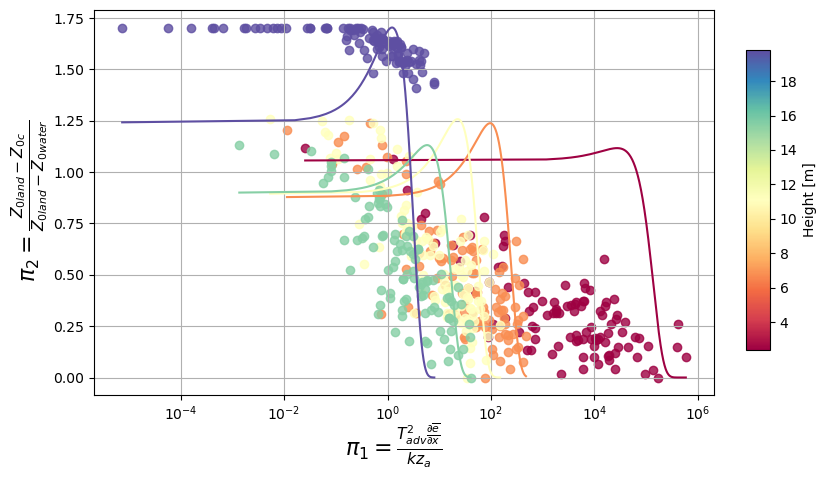

In [283]:
## all z0 below ~50 m

qheight = [2, 5, 10, 20, 50]
#qheight = [1]
mask = (ds.X_coast >= 0) & (ds.X_coast <= 800) & (ds.z0<1000) & (ds.z0>=1e-10) #& (ds.zL<=0.1) & (ds.zL>=-0.1)

X, Z = np.meshgrid(ds.X_coast, ds.Height)

tke_adv = ds.U * calc.first_derivative(ds.TKE, axis='X_coast')
tke = ds.TKE
tadv = (X/ds.U)
z0_land = 0.42
z0_water = 0.00001

#pi1 = ((tadv**1)*(tke**(1/2))/(vonk*Z)).where(mask, drop=True) 
pi2 = ((z0_land - ds.z0)/(z0_land - z0_water)).where(mask, drop=True)
pi1 = ((tadv**2)*np.abs(tke_adv)/(vonk*Z)).where(mask, drop=True) 

N = len(qheight)
cmap = cm.Spectral
colors = cmap(np.linspace(0, 1, N)) 

fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.grid()

for q,h in enumerate(qheight):
    xdata = pi1.interp(Height=h)
    ydata = pi2.interp(Height=h) 
    ydata = ydata + np.abs(np.min(ydata))
    ax.scatter(xdata, ydata, color=colors[q], label=f'z={h}', alpha=0.8)

    x_range = np.linspace(min(xdata), max(xdata), 500)
    gaussian = norm.pdf(x_range, np.nanmean(xdata), np.nanstd(xdata))  # Gaussian in log-space

    # Optional: Scale the Gaussian to match the amplitude of your dataset
    gaussian_scaled = gaussian * max(ydata.values) / max(gaussian)

    ax.plot(x_range, gaussian_scaled, color=colors[q])    


#ax.set_title(f'# of pts: {pi1.size}')
#ax.annotate(r'$\leftarrow$ Lower TKE, Residence time',
#            (1e-2, 1.14), fontsize=10)
#ax.annotate(r'Higher TKE, Residence time $\rightarrow$ ', 
#            (1.2e1, 1.14), fontsize=10)
#ax.annotate(r'$\leftarrow$ Higher $Z_{0c}$', (6e-3, -1.1),  fontsize=10, rotation='vertical')
#ax.annotate(r'Lower $Z_{0c} \rightarrow$ ', (6e-3, 0.5),  fontsize=10, rotation='vertical')

#fig.supxlabel(r'$\pi_1=\frac{T_{adv}\sqrt{\overline{e}}}{kz_a}$', fontsize=16, y=-0.04)
fig.supxlabel(r'$\pi_1=\frac{T_{adv}^2\frac{\partial \overline{e}}{\partial x}}{kz_a}$', fontsize=16, y=-0.04)
fig.supylabel(r'$\pi_2=\frac{Z_{0land}-Z_{0c}}{Z_{0land}-Z_{0water}}$', fontsize=16, x=0.02)

ax.set_xscale('log')
#ax.set_yscale('log')
#ax.set_ylim([-1.4, 1.3])
#ax.set_xlim([5e-3, 3e3])

cax = fig.add_axes([0.94, 0.2, 0.03, 0.6])
fig.colorbar(p1, cax=cax, label='Height [m]')


/var/folders/cs/zh92j6253ql06rbm236klql40000gn/T/ipykernel_63198/2056942373.py:32: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(pi1.interp(Height=h), pi2.interp(Height=h), c=colors[q], label=f'z={h}', alpha=0.8)


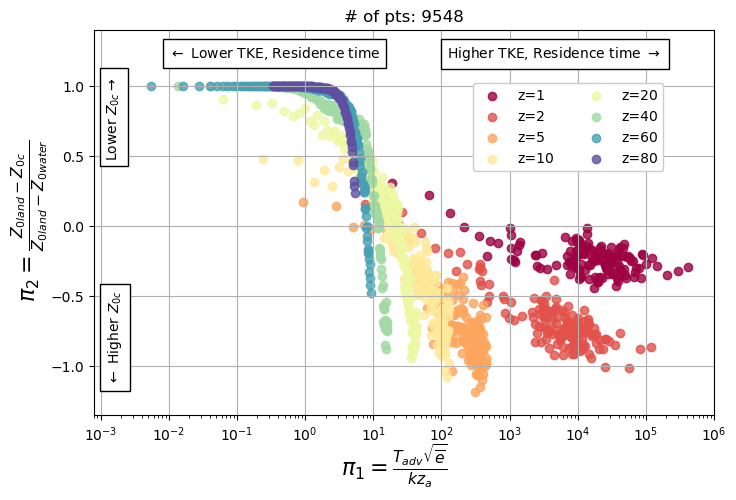

In [562]:
## select heights

qheight = [1, 2, 5, 10, 20, 40, 60, 80]
#qheight = [1]
mask = (ds.X_coast >= 0) & (ds.X_coast <= 1200) & (ds.z0<1000) & (ds.z0>=1e-10) #& (ds.zL<=0.1) & (ds.zL>=-0.1)

X, Z = np.meshgrid(ds.X_coast, ds.Height)

tke_adv = ds.U * calc.first_derivative(ds.TKE, axis='X_coast')
gamma = calc.first_derivative(ds.T, axis='Height')
tke = ds.TKE
tadv = (X/ds.U)
buoyancy = g/ds.T
N2 = buoyancy * gamma
f = 2*np.sin(36.5*np.pi/180)*(7.29e-5)
z0_land = 0.42
z0_water = 0.00001

pi1 = ((tadv**1)*(tke**(1/2))/(vonk*Z)).where(mask, drop=True) 
#pi1 = (X*N2/(ds.U*f)).where(mask, drop=True) 
#pi1 = 1/np.sqrt(X*f/ds.U).where(mask, drop=True) 
pi2 = ((z0_land - ds.z0)/(z0_land+z0_water)).where(mask, drop=True)

N = len(qheight)
cmap = cm.Spectral
colors = cmap(np.linspace(0, 1, N)) 

fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.grid()

for q,h in enumerate(qheight):
    ax.scatter(pi1.interp(Height=h), pi2.interp(Height=h), c=colors[q], label=f'z={h}', alpha=0.8)

ax.set_title(f'# of pts: {pi1.size}')
ax.annotate(r'$\leftarrow$ Lower TKE, Residence time',
            (1e-2, 1.2), fontsize=10,
            bbox=dict(facecolor='white', edgecolor='black'))
ax.annotate(r'Higher TKE, Residence time $\rightarrow$ ', 
            (1.2e2, 1.2), fontsize=10,
            bbox=dict(facecolor='white', edgecolor='black'))
ax.annotate(r'$\leftarrow$ Higher $Z_{0c}$', (1.2e-3, -1.1),  fontsize=10, rotation='vertical', 
            bbox=dict(facecolor='white', edgecolor='black'))
ax.annotate(r'Lower $Z_{0c} \rightarrow$ ', (1.2e-3, 0.5),  fontsize=10, rotation='vertical',
            bbox=dict(facecolor='white', edgecolor='black'))

fig.supxlabel(r'$\pi_1=\frac{T_{adv}\sqrt{\overline{e}}}{kz_a}$', fontsize=16, y=-0.04)
fig.supylabel(r'$\pi_2=\frac{Z_{0land}-Z_{0c}}{Z_{0land}-Z_{0water}}$', fontsize=16, x=0.02)

ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_ylim([-1.35, 1.4])
ax.set_xlim([8e-4, 1e6])
ax.legend(ncol=2, bbox_to_anchor=(0.6, 0.88), framealpha=1)

## best-fit functions

In [9]:
def tanh(x, a, b, c=12):
    return a * np.tanh(b*x) + c

def sinh(x, a, b=20, c=2, d=0):
    #return a * (b - np.exp(-k*x)) + c
    return a*np.sinh(c*x-d)+b

def arc_sinh(x, a, b=20, c=2, d=0):
    #return a * (b - np.exp(-k*x)) + c
    return 1/(a*np.arcsinh(c*x-d)+b)

def cosh(x, a, b, c=0.8, d=0):
    #return a * (b - np.exp(-k*x)) + c
    return a*np.cosh(c*x-d)+b

def mod_tanh(x, a, b, c=1, d=0):
    return c - a*np.tanh(b*x - d)

def neg_logistic(x, a=1, k=1, x0=0, L=1):
    return 1 - (L / (1 + a*np.exp(-k*(x-x0))))

def logistic(x, k=1, x0=0, L=1):
    return L / (1 + np.exp(-k*(x-x0)))

best one

z=2 optimal parameters: a = 0.82, b = 0.00, c = 0.06, d = 0.00
z=5 optimal parameters: a = 0.92, b = 0.01, c = 0.03, d = 0.00
z=10 optimal parameters: a = 1.29, b = 0.01, c = 0.32, d = 0.00
z=20 optimal parameters: a = 1.64, b = 0.02, c = -0.07, d = 0.53
z=40 optimal parameters: a = 1.36, b = 0.14, c = -0.36, d = 1.93
z=60 optimal parameters: a = 1.46, b = 0.27, c = -0.43, d = 2.44


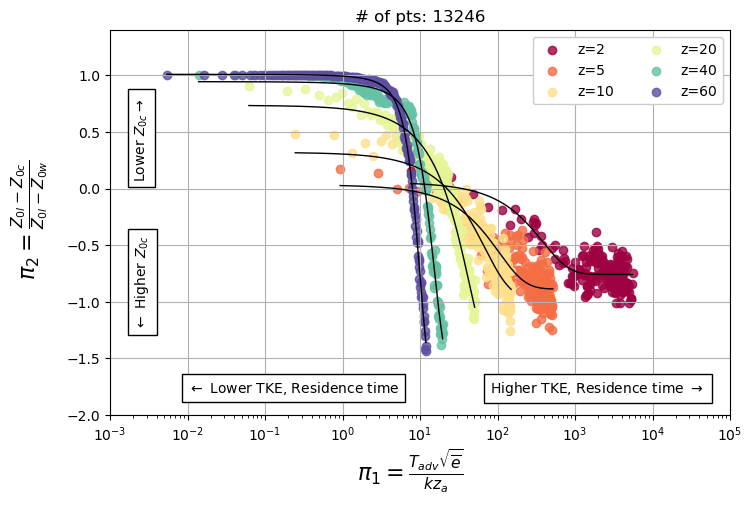

In [373]:
## select heights

qheight = [2, 5, 10, 20, 40, 60]
mask = (ds.X_coast >= 0) & (ds.X_coast <= 1400) & (ds.z0<1000) & (ds.z0>=1e-10) #& (ds.zL<=0.1) & (ds.zL>=-0.1)

X, Z = np.meshgrid(ds.X_coast, ds.Height)

tke = ds.TKE
tadv = (X/ds.hwsp)
z0_land = 0.42
z0_water = 0

pi1 = ((tadv**1)*(tke**(1/2))/(vonk*Z)).where(mask, drop=True) 
pi2 = ((z0_land - ds.z0)/(z0_land - z0_water)).where(mask, drop=True)

N = len(qheight)
cmap = cm.Spectral
colors = cmap(np.linspace(0, 1, N)) 

lower_bounds = np.array([0, 0, -1, 0])
upper_bounds = np.array([5, 2, 2, 10])

opts = np.array([
    [1, 1, 0.5, 1],
    [1, 1, 0.5, 1],
    [1, 1, 0.5, 1],
    [1, 1, 0.5, 1],
    [1, 1, 0.5, 1],
    [1, 1, 0.5, 1],
    [1, 1, 0.5, 1],
])

fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.grid()

popt = np.zeros((len(qheight), 4))

for q,h in enumerate(qheight):
    xdata = pi1.interp(Height=h)
    ydata = pi2.interp(Height=h)
    ax.scatter(xdata, ydata, color=colors[q], label=f'z={h}', alpha=0.8)

    # Fit the model to the data
    #initial_guess = [h/(z0_land-z0_water), 1/h, 2]  # Initial guesses for the parameters a and b
    initial_guess = opts[q]  # Initial guesses for the parameters a and b
    kwargs = {'maxfev': 1000, 'bounds': (lower_bounds, upper_bounds)}
    popt[q,:], pcov = curve_fit(mod_tanh, xdata, ydata, p0=initial_guess, **kwargs)

    # Extract the optimal parameters
    print(f"z={h} optimal parameters: a = {popt[q,0]:.2f}, b = {popt[q,1]:.2f}, c = {popt[q,2]:.2f}, d = {popt[q,3]:.2f}")
    #print(f"z={h} optimal parameters: a = {popt[q,0]:.2f}, b = {popt[q,1]:.2f}, c = {popt[q,2]:.2f}")
    #print(f"z={h} optimal parameters: a = {popt[q,0]:.2f}, b = {popt[q,1]:.2f}")
    xpts = np.linspace(xdata.min(), xdata.max(), 10000)
    #xpts = np.logspace(-2, 5, 10000)
    ax.plot(xpts, mod_tanh(xpts, *popt[q,:]), color='k', lw=1)
    #if q>3: ax.plot(xpts, mod_tanh(xpts, 10, b=0.1, c=1, d=0), color=colors[q], ls='--')

ax.set_title(f'# of pts: {pi1.size}')

ax.annotate(r'$\leftarrow$ Lower TKE, Residence time',
            (1e-2, -1.8), fontsize=10,
            bbox=dict(facecolor='white', edgecolor='black'))
ax.annotate(r'Higher TKE, Residence time $\rightarrow$ ', 
            (8e1, -1.8), fontsize=10,
            bbox=dict(facecolor='white', edgecolor='black'))
ax.annotate(r'$\leftarrow$ Higher $Z_{0c}$', (2e-3, -1.2),  fontsize=10, rotation='vertical', 
            bbox=dict(facecolor='white', edgecolor='black'))
ax.annotate(r'Lower $Z_{0c} \rightarrow$ ', (2e-3, 0.1),  fontsize=10, rotation='vertical',
            bbox=dict(facecolor='white', edgecolor='black'))

fig.supxlabel(r'$\pi_1=\frac{T_{adv}\sqrt{\overline{e}}}{kz_a}$', fontsize=16, y=-0.05)
fig.supylabel(r'$\pi_2=\frac{Z_{0l}-Z_{0c}}{Z_{0l}-Z_{0w}}$', fontsize=16, x=0)

ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_ylim([-2, 1.4])
ax.set_xlim([1e-3, 1e5])
ax.legend(ncol=2, framealpha=1, fontsize='medium')

fig.savefig('z0_pi_sim.png', dpi=200, bbox_inches='tight')
fig.savefig('z0_pi_sim.pdf', dpi=200)

same pi group but for logistic fit

z=2 optimal parameters: k = 0.00, x0 = 0.00, L = 1.76
z=5 optimal parameters: k = 0.02, x0 = 0.00, L = 1.88
z=10 optimal parameters: k = 0.03, x0 = 19.93, L = 1.94
z=20 optimal parameters: k = 0.07, x0 = 24.66, L = 2.32
z=40 optimal parameters: k = 0.29, x0 = 13.40, L = 2.72
z=60 optimal parameters: k = 0.58, x0 = 8.96, L = 2.76


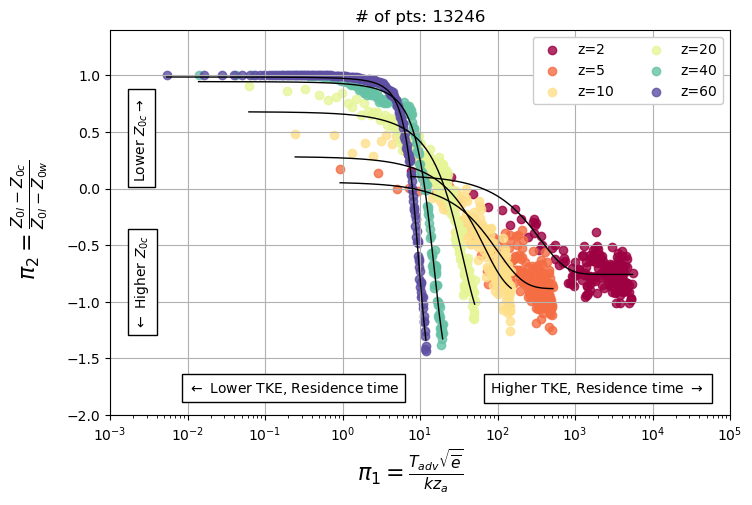

In [51]:
## select heights

qheight = [2, 5, 10, 20, 40, 60]
mask = (ds.X_coast >= 0) & (ds.X_coast <= 1400) & (ds.z0<1000) & (ds.z0>=1e-10) #& (ds.zL<=0.1) & (ds.zL>=-0.1)

X, Z = np.meshgrid(ds.X_coast, ds.Height)

tke = ds.TKE
tadv = (X/ds.hwsp)
z0_land = 0.42
z0_water = 0

pi1 = ((tadv**1)*(tke**(1/2))/(vonk*Z)).where(mask, drop=True) 
pi2 = ((z0_land - ds.z0)/(z0_land - z0_water)).where(mask, drop=True)

N = len(qheight)
cmap = cm.Spectral
colors = cmap(np.linspace(0, 1, N)) 

lower_bounds = np.array([0, 0, 0])
upper_bounds = np.array([0.6, 1000, 10])

opts = np.array([
    [0.01, 1000, 1],
    [0.05, 100, 1],
    [0.1, 80, 1],
    [0.2, 50, 1],
    [0.3, 30, 1],
    [0.5, 10, 1],
    [0.5, 10, 1],
])

#opts = np.ones((N,3))

fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.grid()

popt = np.zeros((len(qheight), 3))

for q,h in enumerate(qheight):
    xdata = pi1.interp(Height=h)
    ydata = pi2.interp(Height=h)
    ax.scatter(xdata, ydata, color=colors[q], label=f'z={h}', alpha=0.8)

    # Fit the model to the data
    #initial_guess = [h/(z0_land-z0_water), 1/h, 2]  # Initial guesses for the parameters a and b
    initial_guess = opts[q]  # Initial guesses for the parameters a and b
    kwargs = {'maxfev': 10000, 'bounds': (lower_bounds, upper_bounds)}
    popt[q,:], pcov = curve_fit(logistic, xdata, ydata, p0=initial_guess, **kwargs)

    # Extract the optimal parameters
    #print(f"z={h} optimal parameters: a = {popt[q,0]:.2f}, b = {popt[q,1]:.2f}, c = {popt[q,2]:.2f}, d = {popt[q,3]:.2f}")
    print(f"z={h} optimal parameters: k = {popt[q,0]:.2f}, x0 = {popt[q,1]:.2f}, L = {popt[q,2]:.2f}")
    #print(f"z={h} optimal parameters: a = {popt[q,0]:.2f}, b = {popt[q,1]:.2f}")
    xpts = np.linspace(xdata.min(), xdata.max(), 10000)
    #xpts = np.logspace(-2, 5, 10000)
    ax.plot(xpts, logistic(xpts, *popt[q,:]), color='k', lw=1)
    #if q>3: ax.plot(xpts, mod_tanh(xpts, 10, b=0.1, c=1, d=0), color=colors[q], ls='--')

ax.set_title(f'# of pts: {pi1.size}')

ax.annotate(r'$\leftarrow$ Lower TKE, Residence time',
            (1e-2, -1.8), fontsize=10,
            bbox=dict(facecolor='white', edgecolor='black'))
ax.annotate(r'Higher TKE, Residence time $\rightarrow$ ', 
            (8e1, -1.8), fontsize=10,
            bbox=dict(facecolor='white', edgecolor='black'))
ax.annotate(r'$\leftarrow$ Higher $Z_{0c}$', (2e-3, -1.2),  fontsize=10, rotation='vertical', 
            bbox=dict(facecolor='white', edgecolor='black'))
ax.annotate(r'Lower $Z_{0c} \rightarrow$ ', (2e-3, 0.1),  fontsize=10, rotation='vertical',
            bbox=dict(facecolor='white', edgecolor='black'))

fig.supxlabel(r'$\pi_1=\frac{T_{adv}\sqrt{\overline{e}}}{kz_a}$', fontsize=16, y=-0.05)
fig.supylabel(r'$\pi_2=\frac{Z_{0l}-Z_{0c}}{Z_{0l}-Z_{0w}}$', fontsize=16, x=0)

ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_ylim([-2, 1.4])
ax.set_xlim([1e-3, 1e5])
ax.legend(ncol=2, framealpha=1, fontsize='medium')

fig.savefig('z0_pi_sim_logistic.png', dpi=200, bbox_inches='tight')
fig.savefig('z0_pi_sim_logistic.pdf', dpi=200)

<>:63: SyntaxWarning: invalid escape sequence '\l'
<>:63: SyntaxWarning: invalid escape sequence '\l'
/var/folders/cs/zh92j6253ql06rbm236klql40000gn/T/ipykernel_99947/1421284608.py:63: SyntaxWarning: invalid escape sequence '\l'
  '''


z=2 optimal parameters: a = 0.29, k = 0.00, x0 = 286.49, L = 0.74
z=5 optimal parameters: a = 0.47, k = 0.01, x0 = 47.27, L = 0.79
z=10 optimal parameters: a = 0.54, k = 0.03, x0 = 43.12, L = 0.81
z=20 optimal parameters: a = 0.62, k = 0.07, x0 = 31.10, L = 0.97
z=40 optimal parameters: a = 0.30, k = 0.29, x0 = 17.60, L = 1.14
z=60 optimal parameters: a = 0.93, k = 0.58, x0 = 9.09, L = 1.16


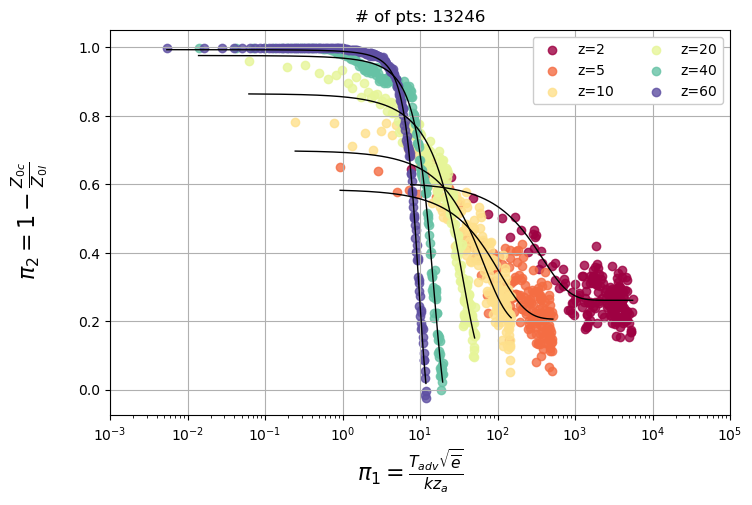

In [86]:
## select heights

qheight = [2, 5, 10, 20, 40, 60]
mask = (ds.X_coast >= 0) & (ds.X_coast <= 1400) & (ds.z0<1000) & (ds.z0>=1e-10) #& (ds.zL<=0.1) & (ds.zL>=-0.1)

X, Z = np.meshgrid(ds.X_coast, ds.Height)

tke = ds.TKE
tadv = (X/ds.hwsp)
z0_land = 1
z0_water = 0

pi1 = ((tadv**1)*(tke**(1/2))/(vonk*Z)).where(mask, drop=True) 
#pi2 = ((z0_land - ds.z0)/(z0_land - z0_water)).where(mask, drop=True)
pi2 = (1 - (ds.z0/z0_land)).where(mask, drop=True)

N = len(qheight)
cmap = cm.Spectral
colors = cmap(np.linspace(0, 1, N)) 

lower_bounds = np.array([0, 0, 0, 0])
upper_bounds = np.array([1, 0.6, 1000, 10])

opts = np.array([
    [1, 0.01, 1000, 1],
    [1, 0.05, 100, 1],
    [1, 0.1, 80, 1],
    [1, 0.2, 50, 1],
    [1, 0.3, 30, 1],
    [1, 0.5, 10, 1],
    [1, 0.5, 10, 1],
])

#opts = np.ones((N,3))

fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.grid()

popt = np.zeros((len(qheight), 4))

for q,h in enumerate(qheight):
    xdata = pi1.interp(Height=h)
    ydata = pi2.interp(Height=h)
    ax.scatter(xdata, ydata, color=colors[q], label=f'z={h}', alpha=0.8)

    # Fit the model to the data
    #initial_guess = [h/(z0_land-z0_water), 1/h, 2]  # Initial guesses for the parameters a and b
    initial_guess = opts[q]  # Initial guesses for the parameters a and b
    kwargs = {'maxfev': 10000, 'bounds': (lower_bounds, upper_bounds)}
    popt[q,:], pcov = curve_fit(neg_logistic, xdata, ydata, p0=initial_guess, **kwargs)

    # Extract the optimal parameters
    print(f"z={h} optimal parameters: a = {popt[q,0]:.2f}, k = {popt[q,1]:.2f}, x0 = {popt[q,2]:.2f}, L = {popt[q,3]:.2f}")
    #print(f"z={h} optimal parameters: k = {popt[q,0]:.2f}, x0 = {popt[q,1]:.2f}, L = {popt[q,2]:.2f}")
    #print(f"z={h} optimal parameters: a = {popt[q,0]:.2f}, b = {popt[q,1]:.2f}")
    xpts = np.linspace(xdata.min(), xdata.max(), 10000)
    #xpts = np.logspace(-2, 5, 10000)
    ax.plot(xpts, neg_logistic(xpts, *popt[q,:]), color='k', lw=1)
    #if q>3: ax.plot(xpts, mod_tanh(xpts, 10, b=0.1, c=1, d=0), color=colors[q], ls='--')

ax.set_title(f'# of pts: {pi1.size}')

'''
ax.annotate(r'$\leftarrow$ Lower TKE, Residence time',
            (1e-2, -1.8), fontsize=10,
            bbox=dict(facecolor='white', edgecolor='black'))
ax.annotate(r'Higher TKE, Residence time $\rightarrow$ ', 
            (8e1, -1.8), fontsize=10,
            bbox=dict(facecolor='white', edgecolor='black'))
ax.annotate(r'$\leftarrow$ Higher $Z_{0c}$', (2e-3, -1.2),  fontsize=10, rotation='vertical', 
            bbox=dict(facecolor='white', edgecolor='black'))
ax.annotate(r'Lower $Z_{0c} \rightarrow$ ', (2e-3, 0.1),  fontsize=10, rotation='vertical',
            bbox=dict(facecolor='white', edgecolor='black'))
'''

fig.supxlabel(r'$\pi_1=\frac{T_{adv}\sqrt{\overline{e}}}{kz_a}$', fontsize=16, y=-0.05)
fig.supylabel(r'$\pi_2=1-\frac{Z_{0c}}{Z_{0l}}$', fontsize=16, x=0)
#fig.supylabel(r'$\pi_2=\frac{Z_{0l}-Z_{0c}}{Z_{0l}-Z_{0w}}$', fontsize=16, x=0)

ax.set_xscale('log')
#ax.set_yscale('log')
#ax.set_ylim([-0.1, 3])
ax.set_xlim([1e-3, 1e5])
ax.legend(ncol=2, framealpha=1, fontsize='medium')

fig.savefig('z0_pi_sim_logistic.png', dpi=200, bbox_inches='tight')
fig.savefig('z0_pi_sim_logistic.pdf', dpi=200)

## Figure

<>:67: SyntaxWarning: invalid escape sequence '\l'
<>:67: SyntaxWarning: invalid escape sequence '\l'
/p/work1/tmp/jhlywiak/ipykernel_194102/336399827.py:67: SyntaxWarning: invalid escape sequence '\l'
  '''


z=2 optimal parameters: k = 0.01, x0 = 0.00, L = 0.86
z=5 optimal parameters: k = 0.06, x0 = 0.00, L = 0.92
z=10 optimal parameters: k = 0.06, x0 = 0.00, L = 0.66
z=20 optimal parameters: k = 0.11, x0 = 5.92, L = 0.33
z=40 optimal parameters: k = 0.27, x0 = 7.91, L = 0.09
z=60 optimal parameters: k = 1.46, x0 = 2.21, L = 0.01


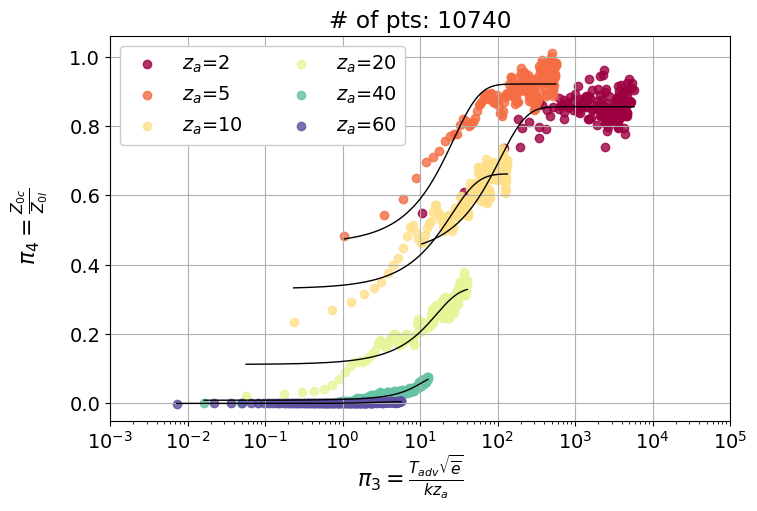

In [22]:
## select heights
plt.rcParams.update({'font.size': 14})

saveplt = 1

qheight = [2, 5, 10, 20, 40, 60]
mask = (ds.X_coast >= 0) & (ds.X_coast <= 1400) & (ds.z0<1000) & (ds.z0>=1e-10) #& (ds.zL<=0.1) & (ds.zL>=-0.1)

X, Z = np.meshgrid(ds.X_coast, ds.Height)

tke = ds.TKE
tadv = (X/ds.hwsp)
z0_land = 1
z0_water = 1e-4

pi1 = ((tadv**1)*(tke**(1/2))/(vonk*Z)).where(mask, drop=True) 
#pi2 = ((z0_land - ds.z0)/(z0_land - z0_water)).where(mask, drop=True)
#pi2 = (ds.z0/z0_land).where(mask, drop=True)
pi2 = (1-(z0_land - ds.z0)/(z0_land - z0_water)).where(mask, drop=True)

N = len(qheight)
cmap = cm.Spectral
colors = cmap(np.linspace(0, 1, N)) 

lower_bounds = np.array([0, 0, 0])
upper_bounds = np.array([1.5, 500, 3])

opts = np.array([
    [1, 0.01, 1000, 1],
    [1, 0.05, 100, 1],
    [1, 0.1, 80, 1],
    [1, 0.2, 50, 1],
    [1, 0.3, 30, 1],
    [1, 0.5, 10, 1],
    [1, 0.5, 10, 1],
])

opts = np.ones((N,3))

fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.grid()

popt = np.zeros((len(qheight), 3))

for q,h in enumerate(qheight):
    xdata = pi1.interp(Height=h)
    ydata = pi2.interp(Height=h)
    ax.scatter(xdata, ydata, color=colors[q], label=f'$z_a$={h}', alpha=0.8)

    # Fit the model to the data
    #initial_guess = [h/(z0_land-z0_water), 1/h, 2]  # Initial guesses for the parameters a and b
    initial_guess = opts[q]  # Initial guesses for the parameters a and b
    kwargs = {'maxfev': 10000, 'bounds': (lower_bounds, upper_bounds)}
    popt[q,:], pcov = curve_fit(logistic, xdata, ydata, p0=initial_guess, **kwargs)

    # Extract the optimal parameters
    #print(f"z={h} optimal parameters: a = {popt[q,0]:.2f}, k = {popt[q,1]:.2f}, x0 = {popt[q,2]:.2f}, L = {popt[q,3]:.2f}")
    print(f"z={h} optimal parameters: k = {popt[q,0]:.2f}, x0 = {popt[q,1]:.2f}, L = {popt[q,2]:.2f}")
    #print(f"z={h} optimal parameters: a = {popt[q,0]:.2f}, b = {popt[q,1]:.2f}")
    xpts = np.linspace(xdata.min().values, xdata.max().values, 10000)
    #xpts = np.logspace(-2, 5, 10000)
    ax.plot(xpts, logistic(xpts, *popt[q,:]), color='k', lw=1)
    #if q>3: ax.plot(xpts, mod_tanh(xpts, 10, b=0.1, c=1, d=0), color=colors[q], ls='--')

ax.set_title(f'# of pts: {pi1.size}')

'''
ax.annotate(r'$\leftarrow$ Lower TKE, Residence time',
            (1e-2, -1.8), fontsize=10,
            bbox=dict(facecolor='white', edgecolor='black'))
ax.annotate(r'Higher TKE, Residence time $\rightarrow$ ', 
            (8e1, -1.8), fontsize=10,
            bbox=dict(facecolor='white', edgecolor='black'))
ax.annotate(r'$\leftarrow$ Higher $Z_{0c}$', (2e-3, -1.2),  fontsize=10, rotation='vertical', 
            bbox=dict(facecolor='white', edgecolor='black'))
ax.annotate(r'Lower $Z_{0c} \rightarrow$ ', (2e-3, 0.1),  fontsize=10, rotation='vertical',
            bbox=dict(facecolor='white', edgecolor='black'))
'''

fig.supxlabel(r'$\pi_3=\frac{T_{adv}\sqrt{\overline{e}}}{kz_a}$', fontsize=16, y=-0.05)
fig.supylabel(r'$\pi_4=\frac{Z_{0c}}{Z_{0l}}$', fontsize=16, x=0)
#fig.supylabel(r'$\pi_2=\frac{Z_{0l}-Z_{0c}}{Z_{0l}-Z_{0w}}$', fontsize=16, x=0)

ax.set_xscale('log')
#ax.set_yscale('log')
#ax.set_ylim([-0.1, 3])
ax.set_xlim([1e-3, 1e5])
ax.legend(ncol=2, framealpha=1, fontsize='medium')

if saveplt == 1:
    fig.savefig('z0_pi_sim_logistic.png', dpi=200, bbox_inches='tight')
    fig.savefig('z0_pi_sim_logistic.pdf', bbox_inches='tight')

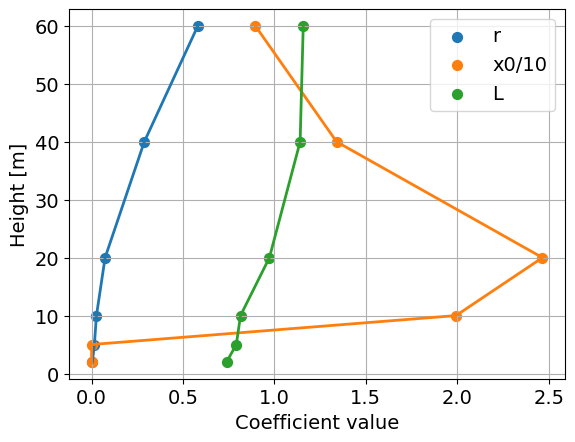

In [9]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1,1)
labels = ['r', 'x0/10', 'L']
#alph = ['Amplitude', 'Shear', 'Intercept', 'Translation']

for n in range(3):
    if n!=1:
        ax.plot(popt[:,n], qheight, label=f'_{alph[n]}', lw=2)
        ax.scatter(popt[:,n], qheight, label=f'{alph[n]}', s=50)
    elif n==1:
        ax.plot(popt[:,n]/10, qheight, label=f'_{alph[n]}', lw=2)
        ax.scatter(popt[:,n]/10, qheight, label=f'{alph[n]}', s=50)

ax.grid()
ax.set_ylabel('Height [m]')
ax.set_xlabel('Coefficient value')
#ax.set_title(r'$\pi_2=f(\pi_1)=c-a*tanh(b\pi_1-d)$')
ax.legend()

fig.savefig('z0_pi_coeff_logistic_e.png', dpi=200, bbox_inches='tight')
fig.savefig('z0_pi_coeff_logistic_e.pdf', bbox_inches='tight')

## Figure 13

$\pi_1=\sqrt{T_{adv}f}$

In [50]:
def logistic(x, k=1, x0=0, L=1):
    return L / (1 + np.exp(-k*(x-x0)))

def loss(params, x, y):
    k, x0, L = params
    return np.sum((logistic(x, k, x0, L) - y)**2)

def tanh(x, k, x0, L):
    return L/2 + k*np.tanh(x-x0)

def loss2(params, x, y):
    k, x0, L = params
    return np.sum((tanh(x, k, x0, L) - y)**2)

def sqrt(x, k, x0, L):
    return L + k*np.sqrt(x*x0)

def loss_sqrt(params, x, y):
    k, x0, L = params
    return np.sum((sqrt(x, k, x0, L) - y)**2)

/p/home/jhlywiak/miniforge3/envs/ABL-lmfit/lib/python3.13/site-packages/xarray/core/computation.py:824: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


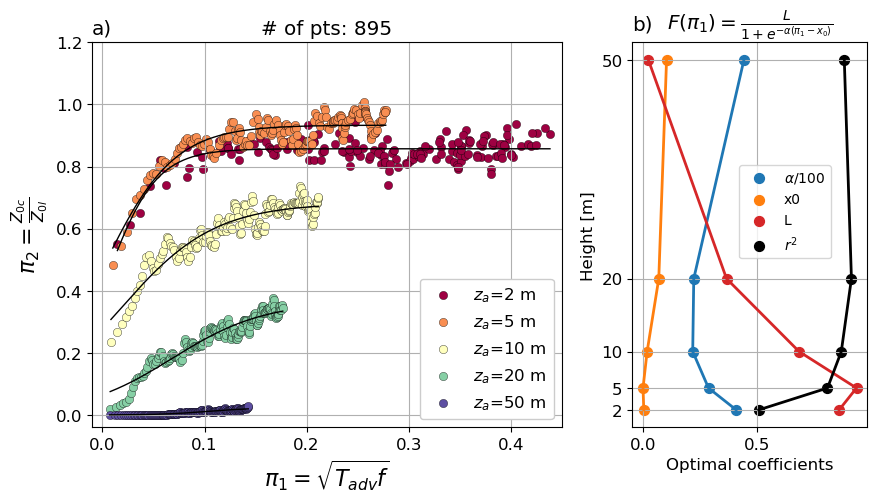

In [69]:
## select heights
plt.rcParams.update({'font.size': 12})
saveplt = 1

qheight = [2, 5, 10, 20, 50]
mask = (ds.X_coast >= 0) & (ds.X_coast <= 1400) & (ds.z0<1000) & (ds.z0>=1e-10) #& (ds.zL<=0.1) & (ds.zL>=-0.1)

X, Z = np.meshgrid(ds.X_coast, ds.Height)

tke = ds.TKE
tadv = (X/ds.hwsp)
z0_land = 1
z0_water = 1e-5
f = 2*np.sin(36.8*np.pi/180)*(7.29e-5)

pi1 = (np.sqrt(tadv*f)).where(mask, drop=True) 
pi2 = (ds.z0/z0_land).where(mask, drop=True)

N = len(qheight)
cmap = cm.Spectral
colors = cmap(np.linspace(0, 1, N)) 

lower_bounds = np.array([0, -0.2, 0])
upper_bounds = np.array([100, 0.2, 1])
bds = Bounds(lb=lower_bounds, ub=upper_bounds)
#lower_bounds = np.array([0, -20, -10, -10])
#upper_bounds = np.array([20, 30, 2, 10])

old_opts = np.array([
    [0.1, 1, 2, 0],
    [1, 1, 1, 0],
    [2, 1, 0, 0],
    [3, 1, -1, 0],
    [4, 1, -2, 1],
    [5, 1, -3, 1],
    [6, 1, -4, 0],
])
opts = np.array([
    [20, 0, 1],
    [20, 0, 1],
    [20, 0, 1],
    [20, 0, 1],
    [20, 0, 1],
    [20, 0.05, 1],
    [20, 0.05, 1],
])

opts = np.ones((N,3))
r2 = np.zeros((len(qheight),))

fig, ax = plt.subplots(1,2, figsize=(10,5), width_ratios=[2,1])
ax=ax.flatten()
ax[0].grid()

popt = np.zeros((len(qheight), 3))
count = 0

for q,h in enumerate(qheight):
    xdata = pi1.interp(Height=h)
    ydata = pi2.interp(Height=h)
    ax[0].scatter(xdata, ydata, color=colors[q], label=f'$z_a$={h} m', alpha=1, ec='k', lw=0.25)
    count += len(xdata)

    ## Fit the model to the data
    #initial_guess = [h/(z0_land-z0_water), 1/h, 2]  # Initial guesses for the parameters a and b
    initial_guess = opts[q]  # Initial guesses for the parameters a and b
    kwargs = {'maxfev': 10000, 'bounds': (lower_bounds, upper_bounds)}
    #popt[q,:], pcov = curve_fit(logistic, xdata, ydata, p0=initial_guess, **kwargs)
    
    ## Using scipy.optimize.minimize
    result = minimize(loss, initial_guess, args=(xdata, ydata), bounds=bds, method='L-BFGS-B')
    popt[q,:] = result.x
    ## If scipy, Compute R² manually
    y_mean = np.mean(ydata)
    yfit = logistic(xdata, *popt[q,:])
    ss_total = np.sum((ydata - y_mean) ** 2)  # Total sum of squares
    ss_residual = np.sum((ydata - yfit) ** 2)  # Residual sum of squares
    r2[q] = 1 - (ss_residual / ss_total)

    ## Using lmfit.Model()
    '''
    log_model = Model(logistic)
    params = log_model.make_params(k=initial_guess[0], x0=initial_guess[1], L=initial_guess[2])
    params['k'].set(min=lower_bounds[0], max=upper_bounds[0])
    params['x0'].set(min=lower_bounds[1], max=upper_bounds[1])
    params['L'].set(min=lower_bounds[2], max=upper_bounds[2])
    result = log_model.fit(ydata, params, x=xdata)
    popt[q,:] = np.array([result.best_values['k'], result.best_values['x0'], result.best_values['L']])
    r2[q] = result.rsquared
    print(result.fit_report())'''

    # Extract the optimal parameters
    #print(f"z={h} optimal parameters: k = {popt[q,0]:.2f}, x0 = {popt[q,1]:.2f}, L = {popt[q,2]:.2f}")
    xpts = np.linspace(xdata.min().values, xdata.max().values, 1000)
    yfit = logistic(xpts, *popt[q,:])
    ax[0].plot(xpts, yfit, color='k', lw=1)
    #ax[0].plot(xpts, logistic(xpts, *popt[q,:]), color='k', lw=1)
    #ax[0].plot(xpts, tanh(xpts, *popt[q,:]), color='k', lw=1)

ax[0].set_title(f'# of pts: {count}')
ax[0].set_xlabel(r'$\pi_1=\sqrt{T_{adv}f}$', fontsize=16)
ax[0].set_ylabel(r'$\pi_2=\frac{Z_{0c}}{Z_{0l}}$', fontsize=16)

#ax.set_xscale('log')
#ax[0].set_yscale('log')
ax[0].set_xlim([-0.01, 0.45])
ax[0].set_ylim([-0.04, 1.2])
ax[0].legend(ncol=1, framealpha=1, fontsize='medium', loc='lower right')

### plot coefficients
labels = [r'$\alpha$/100', 'x0', 'L']
colors = ['C0', 'C1', 'C3']
#alph = ['Amplitude', 'Shear', 'Intercept', 'Translation']

for n in range(3):
    if n!=0:
        ax[1].plot(popt[:,n], qheight, label=f'_{labels[n]}', lw=2, c=colors[n])
        ax[1].scatter(popt[:,n], qheight, label=f'{labels[n]}', s=50, c=colors[n])
    elif n==0:
        ax[1].plot(popt[:,n]/100, qheight, label=f'_{labels[n]}', lw=2, c=colors[n])
        ax[1].scatter(popt[:,n]/100, qheight, label=f'{labels[n]}', s=50, c=colors[n])
ax[1].plot(r2, qheight, lw=2, color='k', label=r'_$r^2$')
ax[1].scatter(r2, qheight, s=50, c='k', label=r'$r^2$')

ax[1].grid()
ax[1].set_ylabel('Height [m]')
ax[1].set_xlabel('Optimal coefficients')
ax[1].set_title(r'$F(\pi_1)=\frac{L}{1+e^{-\alpha (\pi_1-x_0)}}$')
#ax.set_title(r'$\pi_2=f(\pi_1)=c-a*tanh(b\pi_1-d)$')
ax[1].legend(fontsize='small', bbox_to_anchor=(0.65, 0.7))
ax[1].set_yticks(qheight)

ax[0].set_title('a)', loc='left')
ax[1].set_title('b)', loc='left')

if saveplt == 1:
    fig.savefig(f'z0_pi_sim_tadvf_{save_str}.png', dpi=200, bbox_inches='tight')
    fig.savefig(f'z0_pi_sim_tadvf_{save_str}.pdf', bbox_inches='tight')

Just 5, 8.78, 12 m

/p/home/jhlywiak/miniforge3/envs/ABL-lmfit/lib/python3.13/site-packages/xarray/core/computation.py:824: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


z=5 optimal parameters: k = 14.26, x0 = 0.04, L = 0.84
z=8.78 optimal parameters: k = 10.50, x0 = 0.12, L = 1.05
z=11.78 optimal parameters: k = 9.48, x0 = 0.22, L = 1.67


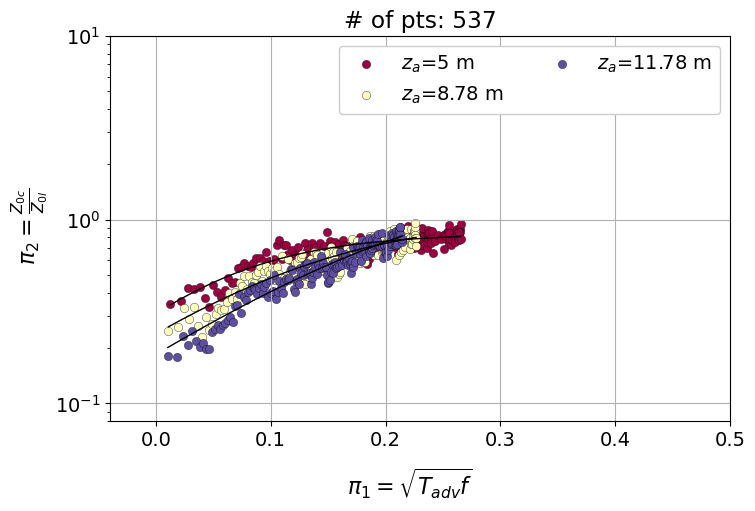

In [61]:
## select heights
plt.rcParams.update({'font.size': 14})
saveplt = 1

qheight = [5, 8.78, 11.78]
mask = (ds.X_coast >= 0) & (ds.X_coast <= 1400) & (ds.z0<1000) & (ds.z0>=1e-10) #& (ds.zL<=0.1) & (ds.zL>=-0.1)

X, Z = np.meshgrid(ds.X_coast, ds.Height)

tke = ds.TKE
tadv = (X/ds.hwsp)
z0_land = 1
z0_water = 0
f = 2*np.sin(36.8*np.pi/180)*(7.29e-5)

pi1 = (np.sqrt(tadv*f)).where(mask, drop=True) 
pi2 = (ds.z0/z0_land).where(mask, drop=True)

N = len(qheight)
cmap = cm.Spectral
colors = cmap(np.linspace(0, 1, N)) 

lower_bounds = np.array([0, -1, 0])
upper_bounds = np.array([100, 2, 1.8])
#lower_bounds = np.array([0, -20, -10, -10])
#upper_bounds = np.array([20, 30, 2, 10])

opts = np.array([
    [0.1, 1, 2, 0],
    [1, 1, 1, 0],
    [2, 1, 0, 0],
    [3, 1, -1, 0],
    [4, 1, -2, 1],
    [5, 1, -3, 1],
    [6, 1, -4, 0],
])

opts = np.ones((N,3))

fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.grid()

popt = np.zeros((len(qheight), 3))
count = 0

for q,h in enumerate(qheight):
    xdata = pi1.interp(Height=h)
    ydata = pi2.interp(Height=h)
    ax.scatter(xdata, ydata, color=colors[q], label=f'$z_a$={h} m', alpha=1, ec='k', lw=0.25)
    count += len(xdata)

    # Fit the model to the data
    #initial_guess = [h/(z0_land-z0_water), 1/h, 2]  # Initial guesses for the parameters a and b
    initial_guess = opts[q]  # Initial guesses for the parameters a and b
    kwargs = {'maxfev': 10000, 'bounds': (lower_bounds, upper_bounds)}
    popt[q,:], pcov = curve_fit(logistic, xdata, ydata, p0=initial_guess, **kwargs)

    # Extract the optimal parameters
    #print(f"z={h} optimal parameters: a = {popt[q,0]:.2f}, b = {popt[q,1]:.2f}, c = {popt[q,2]:.2f}, d = {popt[q,3]:.2f}")
    print(f"z={h} optimal parameters: k = {popt[q,0]:.2f}, x0 = {popt[q,1]:.2f}, L = {popt[q,2]:.2f}")
    #print(f"z={h} optimal parameters: a = {popt[q,0]:.2f}, b = {popt[q,1]:.2f}")
    xpts = np.linspace(xdata.min().values, xdata.max().values, 10000)
    #xpts = np.logspace(-2, 5, 10000)
    ax.plot(xpts, logistic(xpts, *popt[q,:]), color='k', lw=1)
    #if q>3: ax.plot(xpts, mod_tanh(xpts, 10, b=0.1, c=1, d=0), color=colors[q], ls='--')

ax.set_title(f'# of pts: {count}')

#ax.annotate(r'$\leftarrow$ Lower TKE, Residence time',
#            (1e-2, -1.8), fontsize=10,
#            bbox=dict(facecolor='white', edgecolor='black'))
#ax.annotate(r'Higher TKE, Residence time $\rightarrow$ ', 
#            (8e1, -1.8), fontsize=10,
#            bbox=dict(facecolor='white', edgecolor='black'))
#ax.annotate(r'$\leftarrow$ Higher $Z_{0c}$', (2e-3, -1.2),  fontsize=10, rotation='vertical', 
#            bbox=dict(facecolor='white', edgecolor='black'))
#ax.annotate(r'Lower $Z_{0c} \rightarrow$ ', (2e-3, 0.1),  fontsize=10, rotation='vertical',
#            bbox=dict(facecolor='white', edgecolor='black'))

fig.supxlabel(r'$\pi_1=\sqrt{T_{adv}f}$', fontsize=16, y=-0.05)
fig.supylabel(r'$\pi_2=\frac{Z_{0c}}{Z_{0l}}$', fontsize=16, x=0)

#ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([8e-2, 1e1])
ax.set_xlim([-0.04, 0.5])
ax.legend(ncol=2, framealpha=1, fontsize='medium')

if saveplt == 1:
    fig.savefig(f'z0_pi_sim_tadvf_emz_{save_str}.png', dpi=200, bbox_inches='tight')
    fig.savefig(f'z0_pi_sim_tadvf_emz_{save_str}.pdf', bbox_inches='tight')

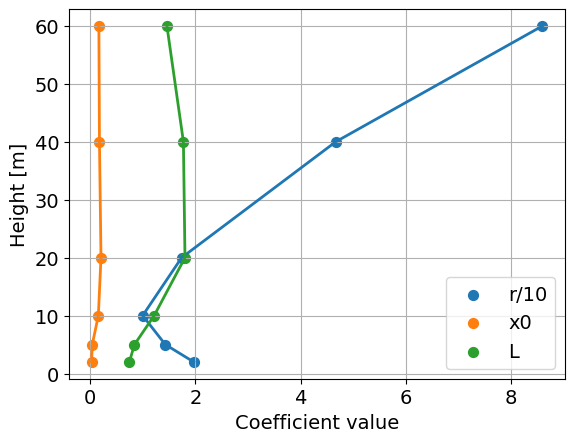

In [11]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1,1)
alph = ['r/10', 'x0', 'L']
#alph = ['Amplitude', 'Shear', 'Intercept', 'Translation']

for n in range(3):
    if n!=0:
        ax.plot(popt[:,n], qheight, label=f'_{alph[n]}', lw=2)
        ax.scatter(popt[:,n], qheight, label=f'{alph[n]}', s=50)
    elif n==0:
        ax.plot(popt[:,n]/10, qheight, label=f'_{alph[n]}', lw=2)
        ax.scatter(popt[:,n]/10, qheight, label=f'{alph[n]}', s=50)

ax.grid()
ax.set_ylabel('Height [m]')
ax.set_xlabel('Coefficient value')
#ax.set_title(r'$\pi_2=f(\pi_1)=c-a*tanh(b\pi_1-d)$')
ax.legend()

fig.savefig('z0_pi_coeff_logistic_tadvf.png', dpi=200, bbox_inches='tight')
fig.savefig('z0_pi_coeff_logistic_tadvf.pdf', bbox_inches='tight')

/Users/jameshlywiak/miniconda3/envs/ABL/lib/python3.12/site-packages/xarray/core/computation.py:818: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


z=2 optimal parameters: a = 0.23, r = 19.72, x0 = 0.10, L = 1.77
z=5 optimal parameters: a = 0.46, r = 14.31, x0 = 0.09, L = 2.00
z=10 optimal parameters: a = 0.52, r = 10.00, x0 = 0.22, L = 2.89
z=20 optimal parameters: a = 0.84, r = 13.39, x0 = 0.37, L = 20.00
z=40 optimal parameters: a = 0.50, r = 46.81, x0 = 0.19, L = 4.22
z=60 optimal parameters: a = 0.41, r = 86.24, x0 = 0.17, L = 3.47


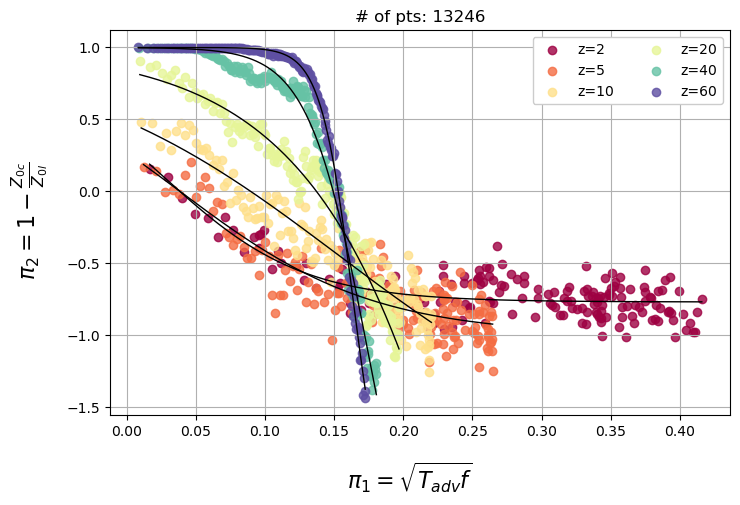

In [84]:
## select heights
saveplt = 1

qheight = [2, 5, 10, 20, 40, 60]
mask = (ds.X_coast >= 0) & (ds.X_coast <= 1400) & (ds.z0<1000) & (ds.z0>=1e-10) #& (ds.zL<=0.1) & (ds.zL>=-0.1)

X, Z = np.meshgrid(ds.X_coast, ds.Height)

tke = ds.TKE
tadv = (X/ds.hwsp)
z0_land = 0.42
z0_water = 0
f = 2*np.sin(36.5*np.pi/180)*(7.29e-5)

pi1 = np.sqrt(tadv*f).where(mask, drop=True) 
pi2 = ((z0_land - ds.z0)/(z0_land - z0_water)).where(mask, drop=True)

N = len(qheight)
cmap = cm.Spectral
colors = cmap(np.linspace(0, 1, N)) 

#lower_bounds = np.array([0, 0, -1, -0.1])
#upper_bounds = np.array([2, 10, 2, 0.5])
lower_bounds = np.array([0, 0, 0, 0])
upper_bounds = np.array([5, 100, 10, 20])

opts = np.array([
    [0.1, 1, 2, 0],
    [1, 1, 1, 0],
    [2, 1, 0, 0],
    [3, 1, -1, 0],
    [4, 1, -2, 1],
    [5, 1, -3, 1],
    [6, 1, -4, 0],
])

opts = np.ones((N,4))

fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.grid()

popt = np.zeros((len(qheight), 4))

for q,h in enumerate(qheight):
    xdata = pi1.interp(Height=h)
    ydata = pi2.interp(Height=h)
    ax.scatter(xdata, ydata, color=colors[q], label=f'z={h}', alpha=0.8)

    # Fit the model to the data
    #initial_guess = [h/(z0_land-z0_water), 1/h, 2]  # Initial guesses for the parameters a and b
    initial_guess = opts[q]  # Initial guesses for the parameters a and b
    kwargs = {'maxfev': 10000, 'bounds': (lower_bounds, upper_bounds)}
    popt[q,:], pcov = curve_fit(neg_logistic, xdata, ydata, p0=initial_guess, **kwargs)

    # Extract the optimal parameters
    print(f"z={h} optimal parameters: a = {popt[q,0]:.2f}, r = {popt[q,1]:.2f}, x0 = {popt[q,2]:.2f}, L = {popt[q,3]:.2f}")
    #print(f"z={h} optimal parameters: k = {popt[q,0]:.2f}, x0 = {popt[q,1]:.2f}, L = {popt[q,2]:.2f}")
    #print(f"z={h} optimal parameters: a = {popt[q,0]:.2f}, b = {popt[q,1]:.2f}")
    xpts = np.linspace(xdata.min(), xdata.max(), 10000)
    #xpts = np.logspace(-2, 5, 10000)
    ax.plot(xpts, neg_logistic(xpts, *popt[q,:]), color='k', lw=1)
    #if q>3: ax.plot(xpts, mod_tanh(xpts, 10, b=0.1, c=1, d=0), color=colors[q], ls='--')

ax.set_title(f'# of pts: {pi1.size}')

#ax.annotate(r'$\leftarrow$ Lower TKE, Residence time',
#            (1e-2, -1.8), fontsize=10,
#            bbox=dict(facecolor='white', edgecolor='black'))
#ax.annotate(r'Higher TKE, Residence time $\rightarrow$ ', 
#            (8e1, -1.8), fontsize=10,
#            bbox=dict(facecolor='white', edgecolor='black'))
#ax.annotate(r'$\leftarrow$ Higher $Z_{0c}$', (2e-3, -1.2),  fontsize=10, rotation='vertical', 
#            bbox=dict(facecolor='white', edgecolor='black'))
#ax.annotate(r'Lower $Z_{0c} \rightarrow$ ', (2e-3, 0.1),  fontsize=10, rotation='vertical',
#            bbox=dict(facecolor='white', edgecolor='black'))

fig.supxlabel(r'$\pi_1=\sqrt{T_{adv}f}$', fontsize=16, y=-0.05)
fig.supylabel(r'$\pi_2=1-\frac{Z_{0c}}{Z_{0l}}$', fontsize=16, x=0)

#ax.set_xscale('log')
#ax.set_yscale('log')
#ax.set_ylim([-2, 1.4])
#ax.set_xlim([1e-3, 1e5])
ax.legend(ncol=2, framealpha=1, fontsize='medium')

if saveplt == 1:
    fig.savefig('z0_pi_sim_tadvf_logistic.png', dpi=200, bbox_inches='tight')
    fig.savefig('z0_pi_sim_tadvf_logistic.pdf', dpi=200)

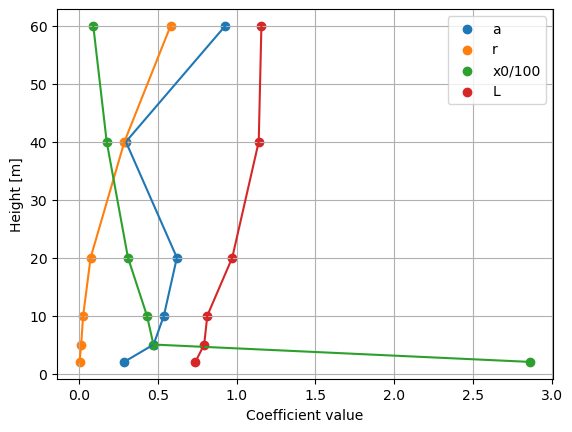

In [90]:
fig, ax = plt.subplots(1,1)
alph = ['a', 'r', 'x0/100', 'L']
#alph = ['Amplitude', 'Shear', 'Intercept', 'Translation']

for n in range(4):
    if n!=2:
        ax.plot(popt[:,n], qheight, label=f'_{alph[n]}')
        ax.scatter(popt[:,n], qheight, label=f'{alph[n]}')
    elif n==2:
        ax.plot(popt[:,n]/100, qheight, label=f'_{alph[n]}')
        ax.scatter(popt[:,n]/100, qheight, label=f'{alph[n]}')

ax.grid()
ax.set_ylabel('Height [m]')
ax.set_xlabel('Coefficient value')
#ax.set_title(r'$\pi_2=f(\pi_1)=c-a*tanh(b\pi_1-d)$')
ax.legend()

fig.savefig('z0_pi_coeff_logistic_e.png', dpi=200, bbox_inches='tight')
fig.savefig('z0_pi_coeff_logistic_e.pdf', dpi=200)

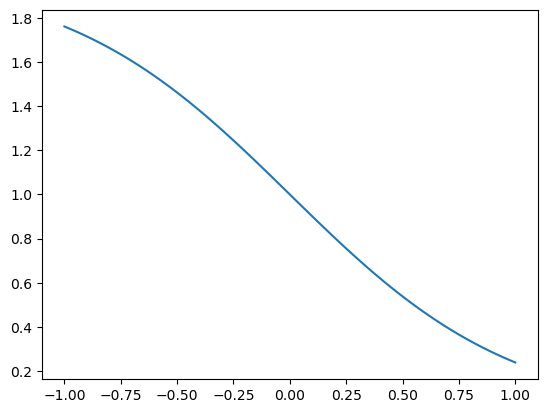

In [318]:
x = np.linspace(-1, 1, 100)
plt.plot(x, 1 - 1*np.tanh(1*x - 0), c='C0')

In [213]:
ds.data_vars

Data variables:
    U        (Height, X_coast) float64 305kB 3.203 3.205 3.202 ... 4.701 4.702
    W        (Height, X_coast) float64 305kB -0.005786 0.006266 ... 0.02308
    V        (Height, X_coast) float64 305kB -0.0147 -0.01553 ... 0.01469
    T        (Height, X_coast) float64 305kB 286.1 286.1 286.1 ... 299.3 299.3
    UpUp     (Height, X_coast) float64 305kB 0.2301 0.2508 ... 0.003109 0.003112
    WpWp     (Height, X_coast) float64 305kB 0.007696 0.007576 ... 0.005745
    VpVp     (Height, X_coast) float64 305kB 0.118 0.1129 ... 0.007077 0.007079
    TKE      (Height, X_coast) float64 305kB 0.1779 0.1856 ... 0.007984 0.007968
    TpTp     (Height, X_coast) float64 305kB 0.01527 0.0009889 ... 0.00905
    UpWp     (Height, X_coast) float64 305kB -0.008249 -0.008026 ... 0.0005816
    WpTp     (Height, X_coast) float64 305kB -0.0008152 -0.0006877 ... -0.002288
    UpVp     (Height, X_coast) float64 305kB -0.05249 -0.04971 ... -1.06e-05
    VpWp     (Height, X_coast) float64 305kB 0

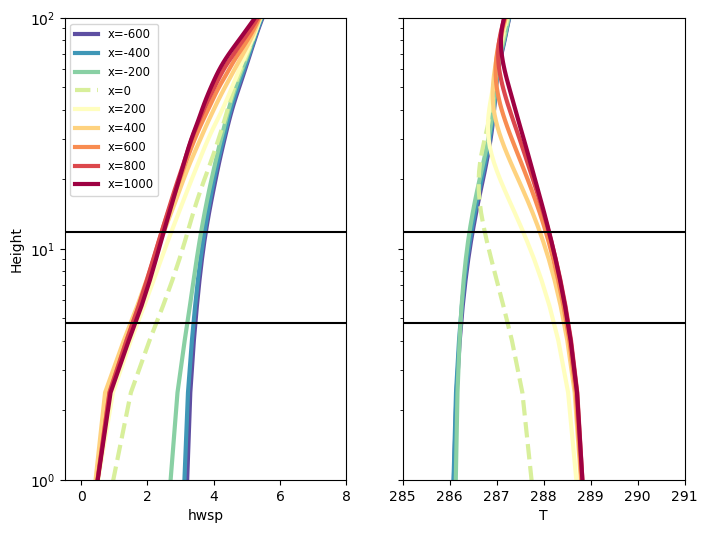

In [416]:
## step back, plot profiles of U(z)
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap

xpos = np.arange(-600, 1001, 200)
N = len(xpos)

cmap = cm.Spectral_r
colors = cmap(np.linspace(0, 1, N)) 

fig, ax = plt.subplots(1,2, figsize=(8,6), sharey=True)

for n in range(N):
    if xpos[n]==0: ls='--'
    elif xpos[n]!=0: ls='-'
    (1*ds.hwsp.interp(X_coast=xpos[n])).plot(y='Height', ax=ax[0], color=colors[n], label=f'x={xpos[n]}', lw=3, ls=ls)
    ds.T.interp(X_coast=xpos[n]).plot(y='Height', ax=ax[1], color=colors[n], label=f'x={xpos[n]}', lw=3, ls=ls)

for a,axis in enumerate(ax):
    if a==0: 
        axis.legend(loc='upper left', fontsize='small')
        axis.set_xlim([-0.5, 8])
    elif a==1: 
        axis.set_xlim([285, 291])
        axis.set_ylabel('')
    axis.set_yscale('log')
    axis.set_ylim([1, 100])
    axis.plot(axis.get_xlim(), [4.78, 4.78], c='k')
    axis.plot(axis.get_xlim(), [11.78, 11.78], c='k')
    axis.set_title('')

(0.75, 20)

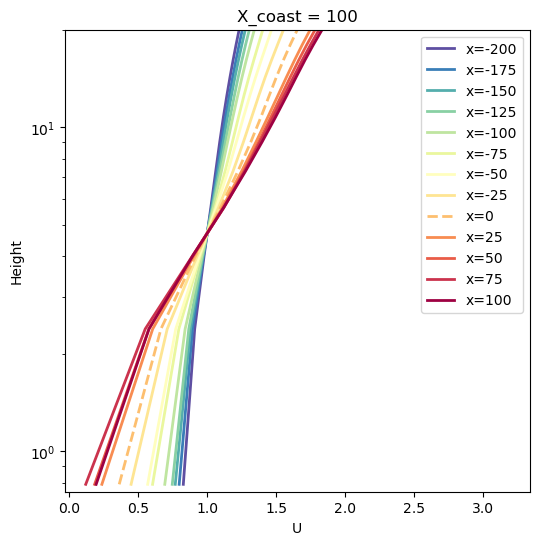

In [19]:
## step back, plot profiles of U(z)
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap

xpos = np.arange(-200, 101, 25)
N = len(xpos)

cmap = cm.Spectral_r
# Generate N colors by sampling the colormap
colors = cmap(np.linspace(0, 1, N))  # Get N evenly spaced colors

fig, ax = plt.subplots(1,1, figsize=(6,6))

for n in range(N):
    wind_plt = ds.U.interp(X_coast=xpos[n])
    wind_plt = wind_plt / wind_plt.interp(Height=4.78)
    if xpos[n] == 0: ls = '--'
    else: ls = '-'
    wind_plt.plot(y='Height', ax=ax, color=colors[n], label=f'x={xpos[n]}', lw=2, ls=ls)

ax.legend()
ax.set_yscale('log')
ax.set_ylim([0.75, 20])

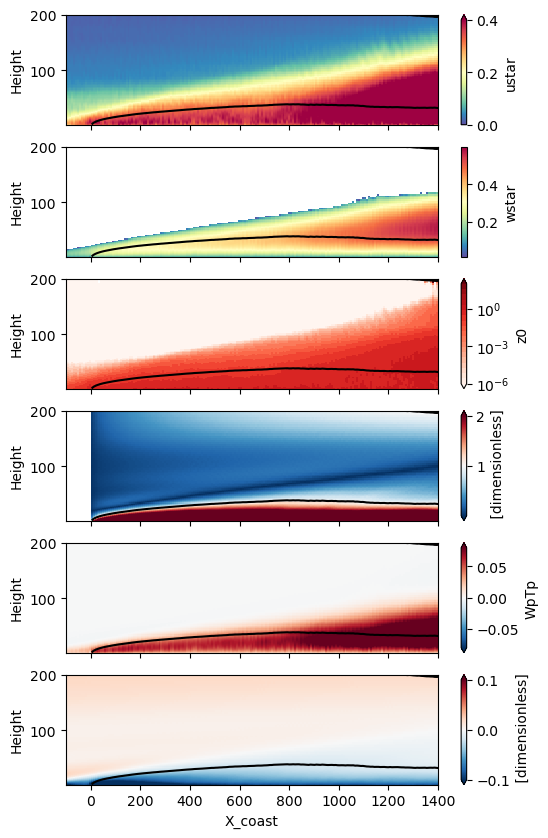

In [349]:
X, Z = np.meshgrid(ds.X_coast.values, ds.Height.values)
gamma = calc.first_derivative(ds.T)
N2 = (g/ds.T)*gamma

non_dim_ibl = ds.WpTp/(gamma*ds.U)
iblh_dyn = (ds.ustar**3/(N*ds.U))**(1/3)
plt_var = (ds.Tadv*N2**2/f)**(1/2)

fig, ax = plt.subplots(6,1, figsize=(6,10), sharex=True)
ax = ax.flatten()

ds.ustar.plot(ax=ax[0], cmap='Spectral_r', vmin=0, vmax=0.4)
ds.wstar.plot(ax=ax[1], cmap='Spectral_r')
ds.z0.where(ds.z0<10000).plot(ax=ax[2], x='X_coast', y='Height', cmap='Reds',extend='both', 
                              levels=np.logspace(1e-6, 100, 20), norm=LogNorm(vmin=1e-6, vmax=100))
plt_var.plot(ax=ax[3], cmap='RdBu_r', vmax=2, extend='both')
ds.WpTp.plot(ax=ax[4], cmap='RdBu_r', vmax=0.08, extend='both')
gamma.plot(ax=ax[5], cmap='RdBu_r', vmax=0.1, extend='both')

for n,axis in enumerate(ax):
    plt_var.plot.contour(ax=axis, levels=[1], colors='k')
    axis.set_ylim([2, 200])
    axis.set_xlim([-100, 1400])
    if n<5: axis.set_xlabel('')

/Users/jameshlywiak/miniconda3/envs/ABL/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/jameshlywiak/miniconda3/envs/ABL/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/jameshlywiak/miniconda3/envs/ABL/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/jameshlywiak/miniconda3/envs/ABL/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/jameshlywiak/miniconda3/envs/ABL/lib/python3.12/site-packages/xarray/core/variable.py:363: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


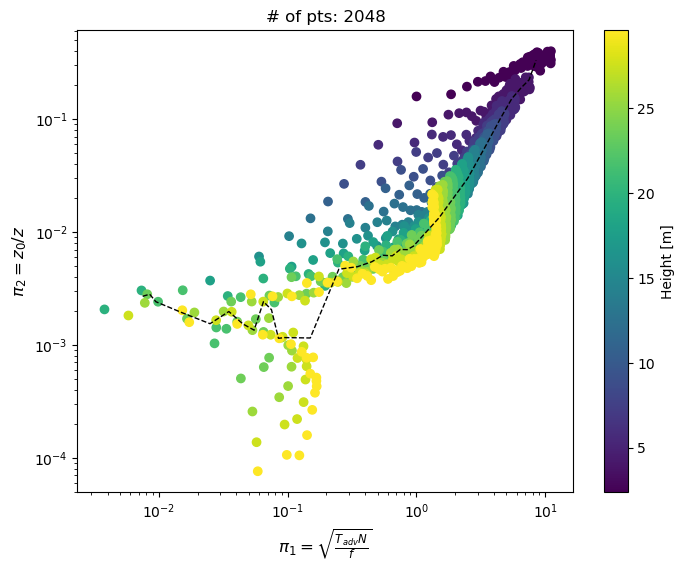

In [353]:
## all z0 below ~50 m

mask = (ds.Height <= 30) & (ds.Height >= 2) & (ds.X_coast<=1000) & (ds.X_coast >= 0) & (ds.z0<100) & (ds.z0>=1e-4)

pi1 = plt_var.where(mask, drop=True)
z0plt = ds.z0.where(mask, drop=True)
zplt = np.transpose(np.tile(z0plt.Height.values, (len(z0plt.X_coast.values), 1)))
pi2 = z0plt/zplt

bins = np.concatenate((
    np.arange(0.001, 0.01, 0.001), 
    np.arange(0.01, 0.1, 0.01), 
    np.arange(0.1, 1, 0.1),
    np.arange(1, 10, 1))
)
#bins = np.arange(0, 12, 0.5)
xplt = (bins[1:]+bins[:-1])/2
medians = np.zeros((len(bins)-1,))
for b,bin in enumerate(bins):
    if b==0: 
        prev_val = bin
    else:
        medians[b-1] = np.nanmedian(pi2.where((pi1>=prev_val) & (pi1<bin), drop=True).values)
        prev_val = bin

fig, ax = plt.subplots(1,1, figsize=(8,6))

p1=ax.scatter(pi1, pi2, c=zplt)
#p2=ax.scatter(xplt, medians, c='k', marker='^', s=100)
p2=ax.plot(xplt, medians, c='k', ls='--', lw=1)

ax.set_title(f'# of pts: {pi1.size}')

fig.colorbar(p1, location='right', label='Height [m]')
ax.set_xlabel(r'$\pi_1=\sqrt{\frac{T_{adv}N}{f}}$', fontsize=12)
ax.set_ylabel(r'$\pi_2=z_0/z$', fontsize=12)
ax.set_xscale('log')
ax.set_yscale('log')

# Read in both LES

have HW already read in, now read in original

In [55]:
LES_data = 'MidPlane_means.csv'
save_str = 'both'

In [56]:
LES_df = pd.read_csv(LES_data)
x_coast = LES_df['X'].unique() - 3000
height = LES_df['Z'].unique()

# Create an xarray Dataset with the 2D data
ds_conv = xr.Dataset(
    coords={
        'Height': height,
        'X_coast': x_coast,
    }
)

for n,name in enumerate(LES_df.columns.to_list()):
    if name=='X' or name=='Z':
        continue
    else:
        # Expand the variables to 2D by repeating along the Z axis (broadcasting)
        var_tmp = LES_df[name].values
        var_2d = np.reshape(var_tmp, (len(height), len(x_coast)))
        
        name = name.replace("'", 'p')
        name = name.replace('THETA', 'T')
        name = name.replace(' ', '')
        ds_conv[name] = (['Height', 'X_coast'], var_2d)   
ds_conv

<xarray.Dataset> Size: 4MB
Dimensions:  (Height: 119, X_coast: 320)
Coordinates:
  * Height   (Height) float64 952B 0.7906 2.384 4.004 5.65 ... 479.7 487.5 495.5
  * X_coast  (X_coast) float64 3kB -996.1 -988.3 -980.5 ... 1.488e+03 1.496e+03
Data variables: (12/13)
    U        (Height, X_coast) float64 305kB 3.203 3.205 3.202 ... 4.701 4.702
    W        (Height, X_coast) float64 305kB -0.005786 0.006266 ... 0.02308
    V        (Height, X_coast) float64 305kB -0.0147 -0.01553 ... 0.01469
    T        (Height, X_coast) float64 305kB 286.1 286.1 286.1 ... 299.3 299.3
    UpUp     (Height, X_coast) float64 305kB 0.2301 0.2508 ... 0.003109 0.003112
    WpWp     (Height, X_coast) float64 305kB 0.007696 0.007576 ... 0.005745
    ...       ...
    TKE      (Height, X_coast) float64 305kB 0.1779 0.1856 ... 0.007984 0.007968
    TpTp     (Height, X_coast) float64 305kB 0.01527 0.0009889 ... 0.00905
    UpWp     (Height, X_coast) float64 305kB -0.008249 -0.008026 ... 0.0005816
    WpTp     (Height, X_coast) float64 305kB -0.0008152 -0.0006877 ... -0.002288
    UpVp     (Height, X_coast) float64 305kB -0.05249 -0.04971 ... -1.06e-05
    VpWp     (Height, X_coast) float64 305kB 0.00974 0.007745 ... -6.96e-05

In [57]:
g = 9.81
vonk = 0.4
f = 2*np.sin(36.8*np.pi/180)*(7.29e-5)

wsp = (ds_conv.U**2 + ds_conv.V**2 + ds_conv.W**2)**(1/2)
hwsp = (ds_conv.U**2 + ds_conv.V**2)**(1/2)
ust = (ds_conv.UpWp**2 + ds_conv.VpWp**2)**(1/4)
wst3 = (ds_conv.Height*g*ds_conv.WpTp / ds_conv.T)**(1)
Lob = -(ds_conv.T*ust**3) / (vonk*g*ds_conv.WpTp)
zL = ds_conv.Height / Lob
Tadv = np.tile(ds_conv.X_coast.values, (len(ds_conv.Height.values), 1)) / ds_conv.U.values
gamma = calc.first_derivative(ds_conv.T)
N2 = (g/ds_conv.T)*gamma

psiu = np.zeros(zL.values.shape, dtype=float)
for z,height in enumerate(ds_conv.Height.values):
    psiu[z,:] = psiu_40(zL.isel(Height=z).values)

psiu[psiu < -100] = np.nan
z0 = np.transpose(np.tile(ds_conv.Height.values, (len(ds_conv.X_coast.values), 1))) * np.exp(-(vonk*wsp/ust + psiu))

ds_conv['wsp'] = (['Height', 'X_coast'], wsp.values)   
ds_conv['hwsp'] = (['Height', 'X_coast'], hwsp.values)   
ds_conv['ustar'] = (['Height', 'X_coast'], ust.values)   
ds_conv['wstar3'] = (['Height', 'X_coast'], wst3.values)   
ds_conv['L_ob'] = (['Height', 'X_coast'], Lob.values)   
ds_conv['zL'] = (['Height', 'X_coast'], zL.values)   
ds_conv['Tadv'] = (['Height', 'X_coast'], Tadv)
ds_conv['z0'] = (['Height', 'X_coast'], z0.values)
ds_conv

<xarray.Dataset> Size: 6MB
Dimensions:  (Height: 119, X_coast: 320)
Coordinates:
  * Height   (Height) float64 952B 0.7906 2.384 4.004 5.65 ... 479.7 487.5 495.5
  * X_coast  (X_coast) float64 3kB -996.1 -988.3 -980.5 ... 1.488e+03 1.496e+03
Data variables: (12/21)
    U        (Height, X_coast) float64 305kB 3.203 3.205 3.202 ... 4.701 4.702
    W        (Height, X_coast) float64 305kB -0.005786 0.006266 ... 0.02308
    V        (Height, X_coast) float64 305kB -0.0147 -0.01553 ... 0.01469
    T        (Height, X_coast) float64 305kB 286.1 286.1 286.1 ... 299.3 299.3
    UpUp     (Height, X_coast) float64 305kB 0.2301 0.2508 ... 0.003109 0.003112
    WpWp     (Height, X_coast) float64 305kB 0.007696 0.007576 ... 0.005745
    ...       ...
    ustar    (Height, X_coast) float64 305kB 0.113 0.1056 ... 0.02537 0.0242
    wstar3   (Height, X_coast) float64 305kB -2.21e-05 -1.864e-05 ... -0.03716
    L_ob     (Height, X_coast) float64 305kB 129.0 124.9 165.0 ... 0.5473 0.4726
    zL       (Height, X_coast) float64 305kB 0.00613 0.00633 ... 905.2 1.048e+03
    Tadv     (Height, X_coast) float64 305kB -311.0 -308.4 ... 316.6 318.2
    z0       (Height, X_coast) float64 305kB 9.71e-06 4.383e-06 ... nan nan

### Figure 13 for both LES

In [74]:
xdata

<xarray.DataArray 'hwsp' (X_coast: 179)> Size: 1kB
array([0.00703741, 0.01217898, 0.0157159 , 0.01858876, 0.0210754 ,
       0.02329597, 0.02532358, 0.02720099, 0.02896008, 0.03061882,
       0.03219562, 0.03370141, 0.03514652, 0.03653514, 0.03787568,
       0.03917222, 0.04042928, 0.0416477 , 0.04283399, 0.0439917 ,
       0.04512405, 0.04623045, 0.04731517, 0.04837963, 0.04942489,
       0.05044871, 0.05145433, 0.05244331, 0.05341715, 0.05437335,
       0.05531334, 0.05623758, 0.05714841, 0.05804673, 0.05893713,
       0.05982078, 0.06069728, 0.06156366, 0.06242245, 0.06327428,
       0.06411695, 0.06494384, 0.06575503, 0.0665533 , 0.06734133,
       0.06811667, 0.06888238, 0.06964582, 0.07041591, 0.07119284,
       0.07197325, 0.07275042, 0.07351788, 0.07426625, 0.07499188,
       0.0756973 , 0.07639168, 0.077082  , 0.07777663, 0.07848216,
       0.07920342, 0.07993502, 0.08066606, 0.08138249, 0.08207573,
       0.08274199, 0.08338518, 0.08401201, 0.08463299, 0.08525746,
       0.08589393, 0.086544  , 0.08720554, 0.08787278, 0.08854094,
       0.08920263, 0.08985113, 0.09047972, 0.09108737, 0.09167588,
       0.09225266, 0.09282832, 0.09341883, 0.09403596, 0.09468293,
       0.09534865, 0.09601373, 0.09665395, 0.09725379, 0.0978135 ,
       0.09835151, 0.09888917, 0.09944142, 0.10001228, 0.10060205,
       0.10120509, 0.10181355, 0.10241785, 0.10301342, 0.10359675,
       0.10416415, 0.10471077, 0.10523904, 0.10575579, 0.10627057,
       0.10679161, 0.10732945, 0.1078897 , 0.10846965, 0.10905633,
       0.1096364 , 0.11019796, 0.11073466, 0.11124738, 0.1117492 ,
       0.11225623, 0.11277703, 0.113307  , 0.1138374 , 0.11436006,
       0.11487098, 0.11536862, 0.11585884, 0.11635389, 0.11686864,
       0.11740894, 0.11796709, 0.11852126, 0.11904912, 0.11953775,
       0.1199908 , 0.12042353, 0.12085875, 0.12131813, 0.12181625,
       0.12235301, 0.12291459, 0.12347605, 0.12401253, 0.1245079 ,
       0.12496413, 0.12539678, 0.12582641, 0.12626685, 0.12672538,
       0.12720504, 0.12770918, 0.12823576, 0.12877541, 0.12931162,
       0.12983128, 0.13032688, 0.13079916, 0.13125316, 0.13170027,
       0.1321517 , 0.13261611, 0.13309609, 0.13359148, 0.13409712,
       0.13460363, 0.13509808, 0.13557357, 0.13603268, 0.13648871,
       0.13695426, 0.13743289, 0.1379143 , 0.13838357, 0.13883207,
       0.13926695, 0.13970424, 0.1401575 , 0.14062613, 0.14109929,
       0.14156457, 0.14201668, 0.14245476, 0.14288145])
Coordinates:
  * X_coast  (X_coast) float64 1kB 3.91 11.72 19.53 ... 1.387e+03 1.395e+03
    Height   int64 8B 50

/p/home/jhlywiak/miniforge3/envs/ABL-lmfit/lib/python3.13/site-packages/xarray/core/computation.py:824: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/p/home/jhlywiak/miniforge3/envs/ABL-lmfit/lib/python3.13/site-packages/xarray/core/computation.py:824: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


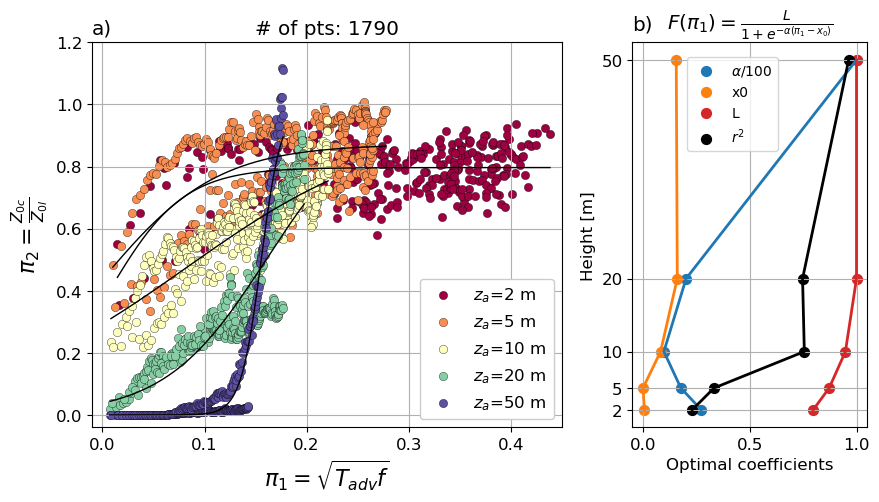

In [80]:
## select heights
plt.rcParams.update({'font.size': 12})
saveplt = 1

qheight = [2, 5, 10, 20, 50]
mask = (ds.X_coast >= 0) & (ds.X_coast <= 1400) & (ds.z0<1000) & (ds.z0>=1e-10) #& (ds.zL<=0.1) & (ds.zL>=-0.1)

z0_water = 1e-5
f = 2*np.sin(36.8*np.pi/180)*(7.29e-5)

## neutral LES
X, Z = np.meshgrid(ds.X_coast, ds.Height)
tke = ds.TKE
tadv = (X/ds.hwsp)
z0_land = 1
pi1_n = (np.sqrt(tadv*f)).where(mask, drop=True) 
pi2_n = (ds.z0/z0_land).where(mask, drop=True)

## conv LES
X, Z = np.meshgrid(ds_conv.X_coast, ds_conv.Height)
tke = ds_conv.TKE
tadv = (X/ds_conv.hwsp)
z0_land = 1
pi1_c = (np.sqrt(tadv*f)).where(mask, drop=True) 
pi2_c = (ds_conv.z0/z0_land).where(mask, drop=True)

N = len(qheight)
cmap = cm.Spectral
colors = cmap(np.linspace(0, 1, N)) 

lower_bounds = np.array([0, -0.2, 0])
upper_bounds = np.array([100, 0.2, 1])
bds = Bounds(lb=lower_bounds, ub=upper_bounds)
opts = np.array([
    [20, 0, 1],
    [20, 0, 1],
    [20, 0, 1],
    [20, 0, 1],
    [20, 0, 1],
    [20, 0.05, 1],
    [20, 0.05, 1],
])

opts = np.ones((N,3))
r2 = np.zeros((len(qheight),))

fig, ax = plt.subplots(1,2, figsize=(10,5), width_ratios=[2,1])
ax=ax.flatten()
ax[0].grid()

popt = np.zeros((len(qheight), 3))
count = 0

for q,h in enumerate(qheight):
    xdata = xr.concat((pi1_n.interp(Height=h), pi1_c.interp(Height=h)), dim='X_coast')
    ydata = xr.concat((pi2_n.interp(Height=h), pi2_c.interp(Height=h)), dim='X_coast')
    ax[0].scatter(xdata, ydata, color=colors[q], label=f'$z_a$={h} m', alpha=1, ec='k', lw=0.25)
    count += len(xdata)

    ## Fit the model to the data
    #initial_guess = [h/(z0_land-z0_water), 1/h, 2]  # Initial guesses for the parameters a and b
    initial_guess = opts[q]  # Initial guesses for the parameters a and b
    kwargs = {'maxfev': 10000, 'bounds': (lower_bounds, upper_bounds)}
    #popt[q,:], pcov = curve_fit(logistic, xdata, ydata, p0=initial_guess, **kwargs)
    
    ## Using scipy.optimize.minimize
    result = minimize(loss, initial_guess, args=(xdata, ydata), bounds=bds, method='L-BFGS-B')
    popt[q,:] = result.x
    ## If scipy, Compute R² manually
    y_mean = np.mean(ydata)
    yfit = logistic(xdata, *popt[q,:])
    ss_total = np.sum((ydata - y_mean) ** 2)  # Total sum of squares
    ss_residual = np.sum((ydata - yfit) ** 2)  # Residual sum of squares
    r2[q] = 1 - (ss_residual / ss_total)

    # Extract the optimal parameters
    #print(f"z={h} optimal parameters: k = {popt[q,0]:.2f}, x0 = {popt[q,1]:.2f}, L = {popt[q,2]:.2f}")
    xpts = np.linspace(xdata.min().values, xdata.max().values, 1000)
    yfit = logistic(xpts, *popt[q,:])
    ax[0].plot(xpts, yfit, color='k', lw=1)
    #ax[0].plot(xpts, logistic(xpts, *popt[q,:]), color='k', lw=1)
    #ax[0].plot(xpts, tanh(xpts, *popt[q,:]), color='k', lw=1)

ax[0].set_title(f'# of pts: {count}')
ax[0].set_xlabel(r'$\pi_1=\sqrt{T_{adv}f}$', fontsize=16)
ax[0].set_ylabel(r'$\pi_2=\frac{Z_{0c}}{Z_{0l}}$', fontsize=16)

#ax.set_xscale('log')
#ax[0].set_yscale('log')
ax[0].set_xlim([-0.01, 0.45])
ax[0].set_ylim([-0.04, 1.2])
ax[0].legend(ncol=1, framealpha=1, fontsize='medium', loc='lower right')

### plot coefficients
labels = [r'$\alpha$/100', 'x0', 'L']
colors = ['C0', 'C1', 'C3']
#alph = ['Amplitude', 'Shear', 'Intercept', 'Translation']

for n in range(3):
    if n!=0:
        ax[1].plot(popt[:,n], qheight, label=f'_{labels[n]}', lw=2, c=colors[n])
        ax[1].scatter(popt[:,n], qheight, label=f'{labels[n]}', s=50, c=colors[n])
    elif n==0:
        ax[1].plot(popt[:,n]/100, qheight, label=f'_{labels[n]}', lw=2, c=colors[n])
        ax[1].scatter(popt[:,n]/100, qheight, label=f'{labels[n]}', s=50, c=colors[n])
ax[1].plot(r2, qheight, lw=2, color='k', label=r'_$r^2$')
ax[1].scatter(r2, qheight, s=50, c='k', label=r'$r^2$')

ax[1].grid()
ax[1].set_ylabel('Height [m]')
ax[1].set_xlabel('Optimal coefficients')
ax[1].set_title(r'$F(\pi_1)=\frac{L}{1+e^{-\alpha (\pi_1-x_0)}}$')
#ax.set_title(r'$\pi_2=f(\pi_1)=c-a*tanh(b\pi_1-d)$')
ax[1].legend(fontsize='small', bbox_to_anchor=(0.65, 0.7))
ax[1].set_yticks(qheight)

ax[0].set_title('a)', loc='left')
ax[1].set_title('b)', loc='left')

if saveplt == 1:
    fig.savefig(f'z0_pi_sim_tadvf_both.png', dpi=200, bbox_inches='tight')
    fig.savefig(f'z0_pi_sim_tadvf_both.pdf', bbox_inches='tight')

## Compare with em0 medians

In [6]:
obs = pd.read_csv('em_tower_medians.csv').set_index(['bins'])
obs = obs.to_xarray()
obs

<xarray.Dataset> Size: 640B
Dimensions:        (bins: 20)
Coordinates:
  * bins           (bins) float64 160B 0.05 0.15 0.25 0.35 ... 1.75 1.85 1.95
Data variables:
    pi_medians     (bins) float64 160B 0.0001668 0.0002141 ... 1.359 1.637
    pi_90ci_upper  (bins) float64 160B 0.002373 0.02057 0.3051 ... 4.496 4.424
    pi_90ci_lower  (bins) float64 160B 1.724e-05 6.658e-06 ... 0.7491 0.7235

In [7]:
obs_all = pd.read_csv('em_tower_all.csv')
obs_all = obs_all.to_xarray()
obs_all

<xarray.Dataset> Size: 344kB
Dimensions:  (index: 14319)
Coordinates:
  * index    (index) int64 115kB 0 1 2 3 4 5 ... 14314 14315 14316 14317 14318
Data variables:
    pix      (index) float64 115kB 0.138 0.1461 0.1476 ... 1.543 1.146 1.099
    piy      (index) float64 115kB 1.987e-05 8.08e-05 ... 0.1634 0.7061

/p/home/jhlywiak/miniforge3/envs/ABL-lmfit/lib/python3.13/site-packages/xarray/core/computation.py:824: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/p/home/jhlywiak/miniforge3/envs/ABL-lmfit/lib/python3.13/site-packages/xarray/core/computation.py:824: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


[2.74342235 1.47502843 1.98056681]
[3.33578637 1.23793652 2.        ]


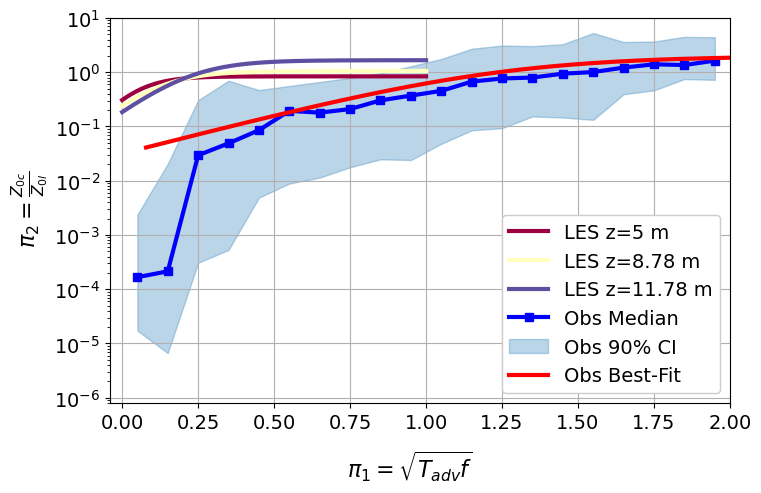

In [72]:
## select heights
plt.rcParams.update({'font.size': 14})
saveplt = 1

qheight = [5, 8.78, 11.78]
mask = (ds.X_coast >= 0) & (ds.X_coast <= 1400) & (ds.z0<1000) & (ds.z0>=1e-10) #& (ds.zL<=0.1) & (ds.zL>=-0.1)

## neutral LES
X, Z = np.meshgrid(ds.X_coast, ds.Height)
tke = ds.TKE
tadv = (X/ds.hwsp)
z0_land = 1
pi1_n = (np.sqrt(tadv*f)).where(mask, drop=True) 
pi2_n = (ds.z0/z0_land).where(mask, drop=True)


## conv LES
X, Z = np.meshgrid(ds_conv.X_coast, ds_conv.Height)
tke = ds_conv.TKE
tadv = (X/ds_conv.hwsp)
z0_land = 1
pi1_c = (np.sqrt(tadv*f)).where(mask, drop=True) 
pi2_c = (ds_conv.z0/z0_land).where(mask, drop=True)

N = len(qheight)
cmap = cm.Spectral
colors = cmap(np.linspace(0, 1, N)) 

lower_bounds = np.array([0, -1, 0])
upper_bounds = np.array([100, 2, 1.8])
bds = Bounds(lb=lower_bounds, ub=upper_bounds)
#lower_bounds = np.array([0, -20, -10, -10])
#upper_bounds = np.array([20, 30, 2, 10])

opts = np.array([
    [0.1, 1, 2, 0],
    [1, 1, 1, 0],
    [2, 1, 0, 0],
    [3, 1, -1, 0],
    [4, 1, -2, 1],
    [5, 1, -3, 1],
    [6, 1, -4, 0],
])

opts = np.ones((N,3))
r2 = np.zeros((3,))

fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.grid()

popt = np.zeros((len(qheight), 3))
count = 0

for q,h in enumerate(qheight):
    #xdata = xr.concat((pi1_n.interp(Height=h), pi1_c.interp(Height=h)), dim='X_coast')
    #ydata = xr.concat((pi2_n.interp(Height=h), pi2_c.interp(Height=h)), dim='X_coast')
    xdata = pi1_c.interp(Height=h)
    ydata = pi2_c.interp(Height=h)
    #ax.scatter(xdata, ydata, color=colors[q], label=f'$z_a$={h} m', alpha=1, ec='k', lw=0.25)
    count += len(xdata)

    ## Fit the model to the data
    #initial_guess = [h/(z0_land-z0_water), 1/h, 2]  # Initial guesses for the parameters a and b
    initial_guess = opts[q]  # Initial guesses for the parameters a and b
    kwargs = {'maxfev': 10000, 'bounds': (lower_bounds, upper_bounds)}
    #popt[q,:], pcov = curve_fit(logistic, xdata, ydata, p0=initial_guess, **kwargs)
    
    ## Using scipy.optimize.minimize
    result = minimize(loss, initial_guess, args=(xdata, ydata), bounds=bds, method='L-BFGS-B')
    popt[q,:] = result.x
    ## If scipy, Compute R² manually
    y_mean = np.mean(ydata)
    yfit = logistic(xdata, *popt[q,:])
    ss_total = np.sum((ydata - y_mean) ** 2)  # Total sum of squares
    ss_residual = np.sum((ydata - yfit) ** 2)  # Residual sum of squares
    r2[q] = 1 - (ss_residual / ss_total)

    # Extract the optimal parameters
    #print(f"z={h} optimal parameters: k = {popt[q,0]:.2f}, x0 = {popt[q,1]:.2f}, L = {popt[q,2]:.2f}")
    #xpts = np.linspace(xdata.min().values, xdata.max().values, 1000)
    xpts = np.linspace(0, 1, 1000)
    yfit = logistic(xpts, *popt[q,:])
    ax.plot(xpts, yfit, color=colors[q], lw=3, label=f'LES z={h} m')

ax.plot(obs.bins, obs.pi_medians, lw=3, c='blue', ls='-', marker='s', label='Obs Median')
ax.fill_between(obs.bins, obs.pi_90ci_lower, obs.pi_90ci_upper, color='C0', alpha=0.3, label='Obs 90% CI')

## Using scipy.optimize.minimize
## training off the medians
xobs = obs.bins
yobs = obs.pi_medians
initial_guess = [20, 0.1, 1]
lower_bounds = np.array([0, -1, -2])
upper_bounds = np.array([100, 2, 2])
bds = Bounds(lb=lower_bounds, ub=upper_bounds)
result = minimize(loss, initial_guess, args=(xobs, yobs), bounds=bds, method='L-BFGS-B')
popt_obs = result.x
print(popt_obs)
## If scipy, Compute R² manually
y_mean_obs = np.mean(yobs)
#popt_obs[0] = 2
#popt_obs[1] = 0.1
yfit = logistic(xobs, *popt_obs)
ss_total = np.sum((ydata - y_mean_obs) ** 2)  # Total sum of squares
ss_residual = np.sum((yobs - yfit) ** 2)  # Residual sum of squares
r2_obs = 1 - (ss_residual / ss_total)

#ax.plot(xobs, yfit, color='k', lw=2, label='Obs Median')
#ax.plot(xobs, 0.1*np.sqrt(5*xobs), color='k', lw=2)

#ax.set_title(f'# of pts: {count}')

## now training off of all scatter points from obs
## Using scipy.optimize.minimize
xobs = obs_all.pix
yobs = obs_all.piy
idx = np.where(xobs<=1.8)[0]

result = minimize(loss, initial_guess, args=(xobs[idx], yobs[idx]), bounds=bds, method='L-BFGS-B')
popt_obs = result.x
print(popt_obs)
## If scipy, Compute R² manually
y_mean_obs = np.mean(yobs)
#popt_obs[0] = 2
#popt_obs[1] = 0.1
xfit = np.sort(obs_all.pix.values)
yfit = logistic(xfit, *popt_obs)
ss_total = np.sum((ydata - y_mean_obs) ** 2)  # Total sum of squares
ss_residual = np.sum((yobs - yfit) ** 2)  # Residual sum of squares
r2_obs = 1 - (ss_residual / ss_total)
ax.plot(xfit, yfit, color='r', lw=3, label='Obs Best-Fit')

fig.supxlabel(r'$\pi_1=\sqrt{T_{adv}f}$', fontsize=16, y=-0.05)
fig.supylabel(r'$\pi_2=\frac{Z_{0c}}{Z_{0l}}$', fontsize=16, x=0)

#ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([8e-7, 1e1])
ax.set_xlim([-0.04, 2])
ax.legend(ncol=1, framealpha=1, fontsize='medium', loc='lower right')

if saveplt == 1:
    fig.savefig(f'z0_pi_sim_tadvf_emz_comp.png', dpi=200, bbox_inches='tight')
    fig.savefig(f'z0_pi_sim_tadvf_emz_comp.pdf', bbox_inches='tight')

In [137]:
obs_all.pix.values

array([0.07868348, 0.07897265, 0.07925738, ..., 3.79127762, 3.85669875,
       4.57155212], shape=(14319,))

/p/work1/tmp/jhlywiak/ipykernel_240344/1597537534.py:4: RuntimeWarning: divide by zero encountered in divide
  plt.plot(x, 1-0.1/np.sinh(0.5*x))


(1e-06, 2)

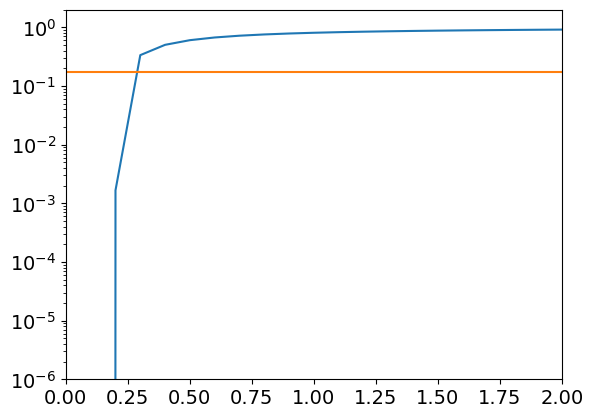

In [ ]:
x = np.linspace(-2, 2, 41)
ps = [0.80375444, 0., 0.17126962]

#plt.plot(x, 1-0.1/np.sinh(0.5*x))
plt.plot(x, sinh(x, *ps))

ax = plt.gca()
ax.set_yscale('log')
ax.set_xlim([0, 2])
ax.set_ylim([1e-6, 2])